#Directory:

1.x - Data Processing

*   1.00: Downloading/File Management

*   1.01: Imports

*   1.02: Processing Turns Data

*   (Note: 1.02 Includes Some Feature Engineering, Including Rolling Windows)

*   1.03: Processing Games Data

*   1.04: Create data_train.csv

*   1.05: Create data_test.csv

*   1.06: Misc. Data Cleaning/Post-Processing

2.x - Data Exploration/Visualization

*   2.01 - Exploration of Player Scores

*   2.02 - Distributions of Turn Types

*   2.03 - Distribution of Move Types

*   2.04 - Outlier Detection

*   2.05 - Overall Visualizations

3.x - Feature Engineering

*   3.01: Generate Features

*   3.02: Merge New Features Into Train/Test Data

*   3.03: Loading and preparing primary model train/test data

4.x - Modeling



#1.X Data Processing

##1.00 - Downloading/file managment

In [ ]:
# Data Processing

In [ ]:

!pwd

/content


In [ ]:
!mkdir /content/kaggle/

In [ ]:
!mkdir /content/kaggle/

In [ ]:
!pip install -q kaggle

In [ ]:
# Follow steps 1 and 2 on this webpage to download the kaggle.json file: https://www.kaggle.com/discussions/general/74235
# Then run this chunk and upload the kaggle.json file you just downloaded.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"spencerstromback","key":"f427ff2eaa4c0c55181924f5510ee2c3"}'}

In [ ]:
!mkdir /root/.kaggle/

In [ ]:
!mv kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c scrabble-player-rating -p /content/kaggle/

 94% 35.0M/37.3M [00:01<00:00, 18.6MB/s]
100% 37.3M/37.3M [00:01<00:00, 20.1MB/s]


In [ ]:
!unzip -o /content/kaggle/scrabble-player-rating.zip -d /content/kaggle/

Archive:  /content/kaggle/scrabble-player-rating.zip
  inflating: /content/kaggle/games.csv  
  inflating: /content/kaggle/sample_submission.csv  
  inflating: /content/kaggle/test.csv  
  inflating: /content/kaggle/train.csv  
  inflating: /content/kaggle/turns.csv  


In [ ]:
!pip install bayesian-optimization==1.4.1

Reason for being yanked: https://github.com/fmfn/BayesianOptimization/pull/388


##1.01 - Imports

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sqlite3
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import xgboost as xgb
import scipy.stats as stats

##1.02 - Processing Turns Data

In [ ]:
# BEGIN PROCESSING TURNS

# Load turns
turns_raw = pd.read_csv('/content/kaggle/turns.csv')
turns = turns_raw

# Add bot column (1/0)
turns['bot'] = (turns['nickname'].str.contains('Bot') & ~turns['nickname'].str.contains('MasterBot'))

# Calculate statistics for scores and turn types (only keeping game_id, nickname, points and turn types)
# (aggregating before the bot/non-bot separation)
aggregated_turns = turns.groupby(['game_id', 'nickname']).agg({
    'points': ['min', 'max', 'mean', 'median', 'std', 'sum', 'count']
}).reset_index()
aggregated_turns.columns = aggregated_turns.columns.map('_'.join).str.strip('_')

# Separate the data into bots and non-bots without re-aggregating
non_bots_df = aggregated_turns[~aggregated_turns['nickname'].str.contains('Bot')]
bots_df = aggregated_turns[aggregated_turns['nickname'].str.contains('Bot')]

# Rename the bot columns to have '_against' suffix
bots_df = bots_df.rename(columns=lambda x: x + '_against' if 'points' in x else x)

# Merge the non-bot and bot dataframes on 'game_id'
turns_final = pd.merge(non_bots_df, bots_df, on='game_id', suffixes=('', '_against'))

# Group by game_id and nickname to count occurrences of each turn_type
turn_type_counts = turns.groupby(['game_id', 'nickname'])['turn_type'].value_counts().unstack(fill_value=0).reset_index()

# Merge the turn_type_counts into the turns_final DataFrame
turns_final = turns_final.merge(turn_type_counts, on=['game_id', 'nickname'], how='left')

# One-Hot Encoding for 'nickname_against'
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(turns_final[['nickname_against']])
one_hot_encoded_frame = pd.DataFrame(encoder.transform(turns_final[['nickname_against']]),
                                     columns=encoder.get_feature_names_out(['nickname_against']))

# Drop 'nickname_against' column
turns_final = turns_final.drop('nickname_against', axis=1)

# Join one-hot encoded df to the original turns_final
turns_final = turns_final.join(one_hot_encoded_frame)

# Inspect the final DataFrame
# print(turns_final.head())
# print(turns_final.columns)



In [ ]:
turns_final

,game_id,nickname,points_min,points_max,points_mean,points_median,points_std,points_sum,points_count,points_min_against,...,Challenge,End,Exchange,Pass,Play,Six-Zero Rule,Timeout,nickname_against_BetterBot,nickname_against_HastyBot,nickname_against_STEEBot
0,1,stevy,2,98,30.642857,25.0,25.490895,429,14,8,...,0,1,0,0,13,0,0,1.0,0.0,0.0
1,2,Super,0,94,34.857143,29.0,30.866604,488,14,8,...,0,1,1,1,11,0,0,1.0,0.0,0.0
2,3,davidavid,13,103,31.428571,28.0,21.689112,440,14,0,...,0,1,0,0,13,0,0,1.0,0.0,0.0
3,4,Inandoutworker,0,26,8.500000,5.5,8.600089,119,14,8,...,0,0,2,0,12,0,0,1.0,0.0,0.0
4,5,stevy,0,51,20.312500,20.5,12.445715,325,16,14,...,0,1,1,0,14,0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72758,72769,browndav,-78,82,21.333333,19.0,37.584415,384,18,9,...,0,1,2,0,14,0,1,0.0,0.0,1.0
72759,72770,samsiah06,-10,24,6.062500,6.0,6.617842,97,16,9,...,0,0,0,0,15,0,1,0.0,1.0,0.0
72760,72771,BB-8,4,83,24.375000,20.5,19.210674,390,16,0,...,0,1,0,0,15,0,0,0.0,1.0,0.0
72761,72772,Gtowngrad,4,67,24.250000,19.0,19.337356,388,16,9,...,0,1,0,0,15,0,0,1.0,0.0,0.0


In [ ]:
# Calculate player stats (all games)
# a dataframe with col1: nicknames and col2+: scores (min, max, mean, median, std, sum)
# *Need to re-join later with final df
# *This is a measure of all the player's stats, not time series
player_stats_all = turns[~turns['bot']][['nickname','points']].groupby('nickname').agg({'points':['min','max','mean','median','std','count']})
player_stats_all = player_stats_all.rename(columns=lambda x: x + '_player_all_games' if 'points' in x else x)
player_stats_all.columns = ['_'.join(col).strip() for col in player_stats_all.columns.values]
player_stats_all.reset_index(inplace=True)
# print(player_stats_all)
# print(player_stats_all.columns)

# Calculate bot stats (all games)
# *Need to re-join later with final df
# *This is a measure of the bot's stats from all games, not time series (because bots are constant)
bot_stats_all = turns[turns['bot']][['nickname','points']].groupby('nickname').agg({'points':['min','max','mean','median','std','count'],'nickname':'first'})
bot_stats_all = bot_stats_all.rename(columns=lambda x: x + '_bot_all_games' if 'points' in x else x)
bot_stats_all.columns = ['_'.join(col).strip() for col in bot_stats_all.columns.values]
bot_stats_all.reset_index(inplace=True)
# print(bot_stats_all)
# print(bot_stats_all.columns)

# Temporarily re-add bot name column
# Define conditions
conditions = [
    turns_final['nickname_against_BetterBot'] == 1.0,
    turns_final['nickname_against_HastyBot'] == 1.0,
    turns_final['nickname_against_STEEBot'] == 1
]

# Define the choices
choices = ['BetterBot', 'HastyBot', 'STEEBot']

# Apply the conditions and choices
turns_final['bot_name'] = np.select(conditions, choices, default='Unknown')
# print(turns_final)
# print(turns_final.columns)

# Add all calculated player and bot stats to turns_final
turns_final = pd.merge(turns_final, player_stats_all, on='nickname', how='left')
turns_final = pd.merge(turns_final, bot_stats_all, left_on='bot_name', right_on='nickname', how='left')
# print(turns_final)
# print(turns_final.columns)
# print(turns_final.head(1).to_string())

In [ ]:
turns_final

,game_id,nickname_x,points_min,points_max,points_mean,points_median,points_std,points_sum,points_count,points_min_against,...,points_player_all_games_std,points_player_all_games_count,nickname_y,points_bot_all_games_min,points_bot_all_games_max,points_bot_all_games_mean,points_bot_all_games_median,points_bot_all_games_std,points_bot_all_games_count,nickname_first
0,1,stevy,2,98,30.642857,25.0,25.490895,429,14,8,...,19.794101,5677,BetterBot,-21,230,26.311325,22.0,19.507798,360931,BetterBot
1,2,Super,0,94,34.857143,29.0,30.866604,488,14,8,...,22.558045,1917,BetterBot,-21,230,26.311325,22.0,19.507798,360931,BetterBot
2,3,davidavid,13,103,31.428571,28.0,21.689112,440,14,0,...,16.150466,3742,BetterBot,-21,230,26.311325,22.0,19.507798,360931,BetterBot
3,4,Inandoutworker,0,26,8.500000,5.5,8.600089,119,14,8,...,24.068704,2622,BetterBot,-21,230,26.311325,22.0,19.507798,360931,BetterBot
4,5,stevy,0,51,20.312500,20.5,12.445715,325,16,14,...,19.794101,5677,STEEBot,-10,221,32.398210,28.0,20.396476,333276,STEEBot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72758,72769,browndav,-78,82,21.333333,19.0,37.584415,384,18,9,...,25.880319,1922,STEEBot,-10,221,32.398210,28.0,20.396476,333276,STEEBot
72759,72770,samsiah06,-10,24,6.062500,6.0,6.617842,97,16,9,...,6.304118,372,HastyBot,-13,302,34.053706,28.0,22.817021,309554,HastyBot
72760,72771,BB-8,4,83,24.375000,20.5,19.210674,390,16,0,...,19.663403,92896,HastyBot,-13,302,34.053706,28.0,22.817021,309554,HastyBot
72761,72772,Gtowngrad,4,67,24.250000,19.0,19.337356,388,16,9,...,16.364457,2093,BetterBot,-21,230,26.311325,22.0,19.507798,360931,BetterBot


In [ ]:
# Calculate the difference in player scores from their global (all games) averages
turns_final['points_min_diff_self'] = turns_final['points_player_all_games_min'] - turns_final['points_min']
turns_final['points_max_diff_self'] = turns_final['points_player_all_games_max'] - turns_final['points_max']
turns_final['points_mean_diff_self'] = turns_final['points_player_all_games_mean'] - turns_final['points_mean']
turns_final['points_median_diff_self'] = turns_final['points_player_all_games_median'] - turns_final['points_median']
turns_final['points_std_diff_self'] = turns_final['points_player_all_games_std'] - turns_final['points_std']
turns_final['points_count_diff_self'] = turns_final['points_player_all_games_count'] - turns_final['points_count']

# Calculate the difference in player scores from their bot opponent (all games)
turns_final['points_min_diff_bot'] = turns_final['points_bot_all_games_min'] - turns_final['points_min']
turns_final['points_max_diff_bot'] = turns_final['points_bot_all_games_max'] - turns_final['points_max']
turns_final['points_mean_diff_bot'] = turns_final['points_bot_all_games_mean'] - turns_final['points_mean']
turns_final['points_median_diff_bot'] = turns_final['points_bot_all_games_median'] - turns_final['points_median']
turns_final['points_std_diff_bot'] = turns_final['points_bot_all_games_std'] - turns_final['points_std']
turns_final['points_count_diff_bot'] = turns_final['points_bot_all_games_count'] - turns_final['points_count']

In [ ]:
turns_final

,game_id,nickname_x,points_min,points_max,points_mean,points_median,points_std,points_sum,points_count,points_min_against,...,points_mean_diff_self,points_median_diff_self,points_std_diff_self,points_count_diff_self,points_min_diff_bot,points_max_diff_bot,points_mean_diff_bot,points_median_diff_bot,points_std_diff_bot,points_count_diff_bot
0,1,stevy,2,98,30.642857,25.0,25.490895,429,14,8,...,-3.837326,-2.0,-5.696794,5663,-23,132,-4.331532,-3.0,-5.983097,360917
1,2,Super,0,94,34.857143,29.0,30.866604,488,14,8,...,-6.229600,-6.0,-8.308560,1903,-21,136,-8.545817,-7.0,-11.358807,360917
2,3,davidavid,13,103,31.428571,28.0,21.689112,440,14,0,...,-7.921089,-8.0,-5.538646,3728,-34,127,-5.117246,-6.0,-2.181315,360917
3,4,Inandoutworker,0,26,8.500000,5.5,8.600089,119,14,8,...,22.440885,20.5,15.468614,2608,-21,204,17.811325,16.5,10.907708,360917
4,5,stevy,0,51,20.312500,20.5,12.445715,325,16,14,...,6.493031,2.5,7.348385,5661,-10,170,12.085710,7.5,7.950760,333260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72758,72769,browndav,-78,82,21.333333,19.0,37.584415,384,18,9,...,4.436698,5.0,-11.704096,1904,68,139,11.064877,9.0,-17.187939,333258
72759,72770,samsiah06,-10,24,6.062500,6.0,6.617842,97,16,9,...,2.190188,1.0,-0.313724,356,-3,278,27.991206,22.0,16.199179,309538
72760,72771,BB-8,4,83,24.375000,20.5,19.210674,390,16,0,...,2.712528,1.5,0.452729,92880,-17,219,9.678706,7.5,3.606347,309538
72761,72772,Gtowngrad,4,67,24.250000,19.0,19.337356,388,16,9,...,-3.636049,-2.0,-2.972899,2077,-25,163,2.061325,3.0,0.170442,360915


In [ ]:
turns_final['Challenge'].value_counts()

0    72763
Name: Challenge, dtype: int64

In [ ]:
### START Calculate the "growth trajectory" (stats from last n games) ###

In [ ]:
turns_sort = turns_final.sort_values(['nickname_x','game_id'], ascending=True).reset_index()
turns_sort.drop('index', axis=1, inplace=True)
turns_sort

,game_id,nickname_x,points_min,points_max,points_mean,points_median,points_std,points_sum,points_count,points_min_against,...,points_mean_diff_self,points_median_diff_self,points_std_diff_self,points_count_diff_self,points_min_diff_bot,points_max_diff_bot,points_mean_diff_bot,points_median_diff_bot,points_std_diff_bot,points_count_diff_bot
0,43828,0188889876,-10,14,0.937500,0.0,4.697074,15,16,0,...,0.000000,0.0,0.000000,0,-3,288,33.116206,28.0,18.119948,309538
1,3765,0927399533,-10,84,14.055556,9.0,22.182325,253,18,6,...,0.891464,3.0,-6.509894,284,-11,146,12.255770,13.0,-2.674528,360913
2,4315,0927399533,-10,32,11.461538,10.0,11.199817,149,13,12,...,3.485481,2.0,4.472614,289,-11,198,14.849787,12.0,8.307981,360918
3,5765,0927399533,-10,35,11.750000,13.0,12.439855,141,12,16,...,3.197020,-1.0,3.232576,290,-11,195,14.561325,9.0,7.067942,360919
4,13443,0927399533,-10,63,14.200000,10.0,16.009818,213,15,8,...,0.747020,2.0,-0.337388,287,-11,167,12.111325,12.0,3.497979,360916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72758,63845,zuzu,12,80,26.416667,21.5,18.515145,317,12,4,...,-1.346667,-1.5,0.454929,88,-33,150,-0.105341,0.5,0.992652,360919
72759,2581,zyzzyva,17,76,39.818182,30.0,20.918022,438,11,13,...,-9.667238,-6.0,-0.660643,42,-27,145,-7.419971,-2.0,-0.521546,333265
72760,23789,zyzzyva,2,92,27.928571,22.0,22.740896,391,14,9,...,2.222372,2.0,-2.483517,39,-12,129,4.469639,6.0,-2.344420,333262
72761,54204,zyzzyva,0,73,27.466667,24.0,20.573446,412,15,0,...,2.684277,0.0,-0.316067,38,-10,148,4.931544,4.0,-0.176970,333261


In [ ]:
turns_sort['Challenge'].value_counts()

0    72763
Name: Challenge, dtype: int64

In [ ]:
# Adding variance column temporarily, will drop after
turns_sort['points_var'] = turns_sort['points_std']**2

# Adding rolling statistics for n days using a function
### CODE GENERATED BY GPT4 ###

def calculate_rolling_stats(df, window_size):
    # Columns to calculate rolling stats for
    stats_columns = ['points_min', 'points_max', 'points_mean', 'points_median', 'points_std', 'points_sum']

    # Remove rows with NaN or 0 game_id first
    df_clean = df.dropna(subset=['game_id'])
    df_clean = df_clean[df_clean['game_id'] != 0]

    # Ensure the DataFrame is sorted
    df_sorted = df_clean.sort_values(['nickname_x', 'game_id'])

    # Define the rolling window
    rolling_stats = df_sorted.groupby('nickname_x')[stats_columns].rolling(window=window_size, min_periods=1).agg({
        'points_min': 'min',
        'points_max': 'max',
        'points_mean': 'mean',
        'points_median': 'median',
        'points_std': 'std',
        'points_sum': 'sum'
    })

    # Drop the 'nickname_x' level from the index
    rolling_stats = rolling_stats.reset_index(level='nickname_x', drop=True)

    # Rename columns to include the window size
    rolling_stats.rename(columns=lambda x: f"{x}_last_{window_size}_games", inplace=True)

    # Join only the rolling stats and game_id back to the original dataframe
    df_final = df_sorted[['game_id']].join(rolling_stats)

    # Replace NaN values with zero
    df_final.fillna(0, inplace=True)

    return df_final

# Define the window sizes
window_sizes = [1, 5, 10, 20]

# Calculate rolling stats for each window size and store them in a dictionary
rolling_stats_by_window = {}
for window_size in window_sizes:
    rolling_stats_by_window[window_size] = calculate_rolling_stats(turns_sort, window_size)

### END GENERATED CHUNK ###

In [ ]:
#rolling_stats_by_window[1].sort_values('game_id')

In [ ]:
turns_final

,game_id,nickname_x,points_min,points_max,points_mean,points_median,points_std,points_sum,points_count,points_min_against,...,points_mean_diff_self,points_median_diff_self,points_std_diff_self,points_count_diff_self,points_min_diff_bot,points_max_diff_bot,points_mean_diff_bot,points_median_diff_bot,points_std_diff_bot,points_count_diff_bot
0,1,stevy,2,98,30.642857,25.0,25.490895,429,14,8,...,-3.837326,-2.0,-5.696794,5663,-23,132,-4.331532,-3.0,-5.983097,360917
1,2,Super,0,94,34.857143,29.0,30.866604,488,14,8,...,-6.229600,-6.0,-8.308560,1903,-21,136,-8.545817,-7.0,-11.358807,360917
2,3,davidavid,13,103,31.428571,28.0,21.689112,440,14,0,...,-7.921089,-8.0,-5.538646,3728,-34,127,-5.117246,-6.0,-2.181315,360917
3,4,Inandoutworker,0,26,8.500000,5.5,8.600089,119,14,8,...,22.440885,20.5,15.468614,2608,-21,204,17.811325,16.5,10.907708,360917
4,5,stevy,0,51,20.312500,20.5,12.445715,325,16,14,...,6.493031,2.5,7.348385,5661,-10,170,12.085710,7.5,7.950760,333260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72758,72769,browndav,-78,82,21.333333,19.0,37.584415,384,18,9,...,4.436698,5.0,-11.704096,1904,68,139,11.064877,9.0,-17.187939,333258
72759,72770,samsiah06,-10,24,6.062500,6.0,6.617842,97,16,9,...,2.190188,1.0,-0.313724,356,-3,278,27.991206,22.0,16.199179,309538
72760,72771,BB-8,4,83,24.375000,20.5,19.210674,390,16,0,...,2.712528,1.5,0.452729,92880,-17,219,9.678706,7.5,3.606347,309538
72761,72772,Gtowngrad,4,67,24.250000,19.0,19.337356,388,16,9,...,-3.636049,-2.0,-2.972899,2077,-25,163,2.061325,3.0,0.170442,360915


In [ ]:
#turns_final['Challenge'].value_counts()

In [ ]:
# Now we join the new columns to our turns_final df
turns_final = pd.merge(turns_final, rolling_stats_by_window[1], on='game_id', how='left')
turns_final = pd.merge(turns_final, rolling_stats_by_window[5], on='game_id', how='left')
turns_final = pd.merge(turns_final, rolling_stats_by_window[10], on='game_id', how='left')
turns_final = pd.merge(turns_final, rolling_stats_by_window[20], on='game_id', how='left')

In [ ]:
turns_final.columns

Index(['game_id', 'nickname_x', 'points_min', 'points_max', 'points_mean',
       'points_median', 'points_std', 'points_sum', 'points_count',
       'points_min_against', 'points_max_against', 'points_mean_against',
       'points_median_against', 'points_std_against', 'points_sum_against',
       'points_count_against', 'Challenge', 'End', 'Exchange', 'Pass', 'Play',
       'Six-Zero Rule', 'Timeout', 'nickname_against_BetterBot',
       'nickname_against_HastyBot', 'nickname_against_STEEBot', 'bot_name',
       'points_player_all_games_min', 'points_player_all_games_max',
       'points_player_all_games_mean', 'points_player_all_games_median',
       'points_player_all_games_std', 'points_player_all_games_count',
       'nickname_y', 'points_bot_all_games_min', 'points_bot_all_games_max',
       'points_bot_all_games_mean', 'points_bot_all_games_median',
       'points_bot_all_games_std', 'points_bot_all_games_count',
       'nickname_first', 'points_min_diff_self', 'points_max_diff

In [ ]:
turns_final

,game_id,nickname_x,points_min,points_max,points_mean,points_median,points_std,points_sum,points_count,points_min_against,...,points_mean_last_10_games,points_median_last_10_games,points_std_last_10_games,points_sum_last_10_games,points_min_last_20_games,points_max_last_20_games,points_mean_last_20_games,points_median_last_20_games,points_std_last_20_games,points_sum_last_20_games
0,1,stevy,2,98,30.642857,25.0,25.490895,429,14,8,...,30.642857,25.00,0.000000,429.0,2.0,98.0,30.642857,25.00,0.000000,429.0
1,2,Super,0,94,34.857143,29.0,30.866604,488,14,8,...,34.857143,29.00,0.000000,488.0,0.0,94.0,34.857143,29.00,0.000000,488.0
2,3,davidavid,13,103,31.428571,28.0,21.689112,440,14,0,...,31.428571,28.00,0.000000,440.0,13.0,103.0,31.428571,28.00,0.000000,440.0
3,4,Inandoutworker,0,26,8.500000,5.5,8.600089,119,14,8,...,8.500000,5.50,0.000000,119.0,0.0,26.0,8.500000,5.50,0.000000,119.0
4,5,stevy,0,51,20.312500,20.5,12.445715,325,16,14,...,25.477679,22.75,9.224335,754.0,0.0,98.0,25.477679,22.75,9.224335,754.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72758,72769,browndav,-78,82,21.333333,19.0,37.584415,384,18,9,...,26.888429,22.50,7.233177,3368.0,-78.0,96.0,28.173093,23.50,7.709127,7245.0
72759,72770,samsiah06,-10,24,6.062500,6.0,6.617842,97,16,9,...,8.190579,7.75,1.425768,1243.0,-10.0,42.0,8.383713,7.50,1.847201,2577.0
72760,72771,BB-8,4,83,24.375000,20.5,19.210674,390,16,0,...,28.364355,22.50,6.066101,3928.0,0.0,149.0,27.375057,22.25,5.480276,7699.0
72761,72772,Gtowngrad,4,67,24.250000,19.0,19.337356,388,16,9,...,22.603655,17.25,5.928524,3430.0,-10.0,102.0,21.025521,16.00,4.623718,6425.0


In [ ]:
turns_final.drop('nickname_first', inplace=True, axis=1)
turns_final.drop('nickname_x', inplace=True, axis=1)
turns_final.drop('nickname_y', inplace=True, axis=1)
turns_final.drop('bot_name', inplace=True, axis=1)
turns_final.to_csv('/content/kaggle/turns_clean.csv', index=False)

In [ ]:
turns_final.head(5)

,game_id,points_min,points_max,points_mean,points_median,points_std,points_sum,points_count,points_min_against,points_max_against,...,points_mean_last_10_games,points_median_last_10_games,points_std_last_10_games,points_sum_last_10_games,points_min_last_20_games,points_max_last_20_games,points_mean_last_20_games,points_median_last_20_games,points_std_last_20_games,points_sum_last_20_games
0,1,2,98,30.642857,25.0,25.490895,429,14,8,68,...,30.642857,25.00,0.000000,429.0,2.0,98.0,30.642857,25.00,0.000000,429.0
1,2,0,94,34.857143,29.0,30.866604,488,14,8,85,...,34.857143,29.00,0.000000,488.0,0.0,94.0,34.857143,29.00,0.000000,488.0
2,3,13,103,31.428571,28.0,21.689112,440,14,0,76,...,31.428571,28.00,0.000000,440.0,13.0,103.0,31.428571,28.00,0.000000,440.0
3,4,0,26,8.500000,5.5,8.600089,119,14,8,74,...,8.500000,5.50,0.000000,119.0,0.0,26.0,8.500000,5.50,0.000000,119.0
4,5,0,51,20.312500,20.5,12.445715,325,16,14,81,...,25.477679,22.75,9.224335,754.0,0.0,98.0,25.477679,22.75,9.224335,754.0


In [ ]:
turns_final.columns

Index(['game_id', 'points_min', 'points_max', 'points_mean', 'points_median',
       'points_std', 'points_sum', 'points_count', 'points_min_against',
       'points_max_against', 'points_mean_against', 'points_median_against',
       'points_std_against', 'points_sum_against', 'points_count_against',
       'Challenge', 'End', 'Exchange', 'Pass', 'Play', 'Six-Zero Rule',
       'Timeout', 'nickname_against_BetterBot', 'nickname_against_HastyBot',
       'nickname_against_STEEBot', 'points_player_all_games_min',
       'points_player_all_games_max', 'points_player_all_games_mean',
       'points_player_all_games_median', 'points_player_all_games_std',
       'points_player_all_games_count', 'points_bot_all_games_min',
       'points_bot_all_games_max', 'points_bot_all_games_mean',
       'points_bot_all_games_median', 'points_bot_all_games_std',
       'points_bot_all_games_count', 'points_min_diff_self',
       'points_max_diff_self', 'points_mean_diff_self',
       'points_median_dif

##1.03: Processing Games Data

In [ ]:
### BEGIN PROCESSING GAMES

games_raw = pd.read_csv('/content/kaggle/games.csv')

games = games_raw

# Add hour created and day of week columns
games['created_at'] = pd.to_datetime(games['created_at'])
games['created_at_hour'] = games['created_at'].dt.hour
games['created_at_day'] = games['created_at'].dt.dayofweek

games.drop('created_at', axis=1, inplace=True)

# One-Hot Encoding
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Columns to be one-hot encoded
columns_to_encode = ['time_control_name', 'game_end_reason', 'rating_mode', 'lexicon', 'created_at_hour', 'created_at_day']

# Fit the encoder on the specified columns
encoder.fit(games[columns_to_encode])

# Transform the data and convert to a dataframe
one_hot_encoded_array = encoder.transform(games[columns_to_encode])
one_hot_encoded_columns = encoder.get_feature_names_out(columns_to_encode)
one_hot_encoded_frame = pd.DataFrame(one_hot_encoded_array, columns=one_hot_encoded_columns)

# Drop the original columns from games as they will be replaced by the one-hot encoded columns
games.drop(columns_to_encode, axis=1, inplace=True)

# Reset index on games dataframe to allow for a proper join if indexes are not aligned
games.reset_index(drop=True, inplace=True)

# Join the one-hot encoded dataframe to the original games dataframe
# Make sure the indexes correspond to the same rows in both dataframes
games = games.join(one_hot_encoded_frame)

# Make bot_first column
games['bot_first'] = (games['first'].str.contains('Bot') & ~games['first'].str.contains('MasterBot'))
games['bot_first'] = games['bot_first'].astype(int)
games.drop('first', axis=1, inplace=True)

# print(games.head(5))
# print(games.columns)

games.to_csv('/content/kaggle/games_clean.csv', index=False)

In [ ]:
games.head(5)

,game_id,winner,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,time_control_name_blitz,time_control_name_rapid,time_control_name_regular,time_control_name_ultrablitz,...,created_at_hour_22,created_at_hour_23,created_at_day_0,created_at_day_1,created_at_day_2,created_at_day_3,created_at_day_4,created_at_day_5,created_at_day_6,bot_first
0,1,1,1200,0,1,674.844274,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,2,1,3600,0,1,364.214418,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,3,1,900,0,5,492.268262,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,4,0,3600,0,1,350.861141,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,5,0,1200,0,1,642.688722,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
games.columns

Index(['game_id', 'winner', 'initial_time_seconds', 'increment_seconds',
       'max_overtime_minutes', 'game_duration_seconds',
       'time_control_name_blitz', 'time_control_name_rapid',
       'time_control_name_regular', 'time_control_name_ultrablitz',
       'game_end_reason_CONSECUTIVE_ZEROES', 'game_end_reason_RESIGNED',
       'game_end_reason_STANDARD', 'game_end_reason_TIME',
       'rating_mode_CASUAL', 'rating_mode_RATED', 'lexicon_CSW21',
       'lexicon_ECWL', 'lexicon_NSWL20', 'lexicon_NWL20', 'created_at_hour_0',
       'created_at_hour_1', 'created_at_hour_2', 'created_at_hour_3',
       'created_at_hour_4', 'created_at_hour_5', 'created_at_hour_6',
       'created_at_hour_7', 'created_at_hour_8', 'created_at_hour_9',
       'created_at_hour_10', 'created_at_hour_11', 'created_at_hour_12',
       'created_at_hour_13', 'created_at_hour_14', 'created_at_hour_15',
       'created_at_hour_16', 'created_at_hour_17', 'created_at_hour_18',
       'created_at_hour_19', 'creat

##1.04: Create data_train.csv

In [ ]:
### BEGIN PROCESSING TRAIN
train_raw = pd.read_csv('/content/kaggle/train.csv')

train = train_raw

### USE THIS CHUNK OF CODE IF YOU WANT TO EXCLUDE CASUAL GAMES FROM TRAINING DATA ###

# train = train[train['rating_mode'] == 'RATED']
# train.drop('rating_mode_CASUAL', axis=1, inplace=True)
# train.drop('rating_mode_RATED', axis=1, inplace=True)

# Remove bot rows
train = train[~(train['nickname'].str.contains('Bot') | train['nickname'].str.contains('MasterBot'))]

# score column is already captured in turns_clean df (max_score and max_score_against)
train.drop(['nickname', 'score'], inplace=True, axis=1)

# print(train.head(10).to_string())
# print(train.columns)

train.to_csv('/content/kaggle/train_clean.csv', index=False)

train_clean = pd.read_csv('/content/kaggle/train_clean.csv')
games_clean = pd.read_csv('/content/kaggle/games_clean.csv')
turns_clean = pd.read_csv('/content/kaggle/turns_clean.csv')

# print(train_clean.head(10).to_string())
# print(games_clean.head(10).to_string())
# print(turns_clean.head(10).to_string())

merge = pd.merge(train_clean, games_clean, on='game_id', how='left')
merge = pd.merge(merge, turns_clean, on='game_id', how='left')

merge.drop(['Challenge','points_std_last_1_games'], axis=1, inplace=True)

# print(merge.head(5))
# print(merge.columns)
# print(len(merge))

merge.to_csv('/content/kaggle/data_train.csv', index=False)

<ipython-input-37-f502cd3dd203>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['nickname', 'score'], inplace=True, axis=1)


In [ ]:
merge.head(5)

,game_id,rating,winner,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,time_control_name_blitz,time_control_name_rapid,time_control_name_regular,...,points_mean_last_10_games,points_median_last_10_games,points_std_last_10_games,points_sum_last_10_games,points_min_last_20_games,points_max_last_20_games,points_mean_last_20_games,points_median_last_20_games,points_std_last_20_games,points_sum_last_20_games
0,1,1500,1,1200,0,1,674.844274,0.0,0.0,1.0,...,30.642857,25.00,0.000000,429.0,2.0,98.0,30.642857,25.00,0.000000,429.0
1,3,1811,1,900,0,5,492.268262,0.0,0.0,1.0,...,31.428571,28.00,0.000000,440.0,13.0,103.0,31.428571,28.00,0.000000,440.0
2,4,1473,0,3600,0,1,350.861141,0.0,0.0,1.0,...,8.500000,5.50,0.000000,119.0,0.0,26.0,8.500000,5.50,0.000000,119.0
3,5,1500,0,1200,0,1,642.688722,0.0,0.0,1.0,...,25.477679,22.75,9.224335,754.0,0.0,98.0,25.477679,22.75,9.224335,754.0
4,6,2029,0,900,0,1,426.950541,0.0,0.0,1.0,...,31.500000,28.50,0.000000,378.0,8.0,74.0,31.500000,28.50,0.000000,378.0


In [ ]:
merge.columns

Index(['game_id', 'rating', 'winner', 'initial_time_seconds',
       'increment_seconds', 'max_overtime_minutes', 'game_duration_seconds',
       'time_control_name_blitz', 'time_control_name_rapid',
       'time_control_name_regular',
       ...
       'points_mean_last_10_games', 'points_median_last_10_games',
       'points_std_last_10_games', 'points_sum_last_10_games',
       'points_min_last_20_games', 'points_max_last_20_games',
       'points_mean_last_20_games', 'points_median_last_20_games',
       'points_std_last_20_games', 'points_sum_last_20_games'],
      dtype='object', length=123)

##1.05: Create data_test.csv

In [ ]:
### BEGIN PROCESSING TEST
test_raw = pd.read_csv('/content/kaggle/test.csv')

test = test_raw

# Remove bot rows
test = test[(~test['nickname'].str.contains('Bot') | test['nickname'].str.contains('MasterBot'))]

# score column is already captured in turns_clean df (max_score and max_score_against)
test.drop(['nickname', 'score'], inplace=True, axis=1)

# test['rating'] = pd.Na

# print(test.head(10).to_string())
# print(test.columns)

test.to_csv('/content/kaggle/test_clean.csv', index=False)

### BEGIN CREATE DATA_TEST
test_clean = pd.read_csv('/content/kaggle/test_clean.csv')

# print(test_clean.head(10).to_string())

merge2 = pd.merge(test_clean, games_clean, on='game_id', how='left')
merge2 = pd.merge(merge2, turns_clean, on='game_id', how='left')

# Dropping a null value column
merge2.drop(['Challenge','points_std_last_1_games'], axis=1, inplace=True)

# print(merge2.head(5))
# print(merge2.columns)
# print(len(merge2))

merge2.to_csv('/content/kaggle/data_test.csv', index=False)

<ipython-input-40-8d05de93308e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['nickname', 'score'], inplace=True, axis=1)


In [ ]:
merge2.head(5)

,game_id,rating,winner,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,time_control_name_blitz,time_control_name_rapid,time_control_name_regular,...,points_mean_last_10_games,points_median_last_10_games,points_std_last_10_games,points_sum_last_10_games,points_min_last_20_games,points_max_last_20_games,points_mean_last_20_games,points_median_last_20_games,points_std_last_20_games,points_sum_last_20_games
0,2,NaN,1,3600,0,1,364.214418,0.0,0.0,1.0,...,34.857143,29.0,0.0,488.0,0.0,94.0,34.857143,29.0,0.0,488.0
1,7,NaN,1,1260,0,1,385.599607,0.0,0.0,1.0,...,29.153846,23.0,0.0,379.0,0.0,68.0,29.153846,23.0,0.0,379.0
2,11,NaN,1,1200,0,1,501.739156,0.0,0.0,1.0,...,33.000000,30.0,0.0,462.0,0.0,66.0,33.000000,30.0,0.0,462.0
3,14,NaN,0,900,0,1,293.253051,0.0,0.0,1.0,...,23.933333,21.0,0.0,359.0,4.0,98.0,23.933333,21.0,0.0,359.0
4,27,NaN,1,1200,0,1,203.963230,0.0,0.0,1.0,...,41.454545,37.0,0.0,456.0,9.0,90.0,41.454545,37.0,0.0,456.0


In [ ]:
merge2.columns

Index(['game_id', 'rating', 'winner', 'initial_time_seconds',
       'increment_seconds', 'max_overtime_minutes', 'game_duration_seconds',
       'time_control_name_blitz', 'time_control_name_rapid',
       'time_control_name_regular',
       ...
       'points_mean_last_10_games', 'points_median_last_10_games',
       'points_std_last_10_games', 'points_sum_last_10_games',
       'points_min_last_20_games', 'points_max_last_20_games',
       'points_mean_last_20_games', 'points_median_last_20_games',
       'points_std_last_20_games', 'points_sum_last_20_games'],
      dtype='object', length=123)

##1.06: Misc. Data Cleaning/Post-Processing

In [ ]:
# Checking data sparsity

def return_binary_df(df):
  binary_check = df.isin([0, 1]) | df.isnull()
  binary_cols = binary_check.all(axis=0)
  return_df = df.loc[:, binary_cols]
  return return_df

merge_binary = return_binary_df(merge)
merge2_binary = return_binary_df(merge2)

In [ ]:
merge_binary_value_counts = merge_binary.apply(pd.Series.value_counts)
merge_binary_value_counts

,time_control_name_blitz,time_control_name_rapid,time_control_name_regular,time_control_name_ultrablitz,game_end_reason_CONSECUTIVE_ZEROES,game_end_reason_RESIGNED,game_end_reason_STANDARD,game_end_reason_TIME,rating_mode_CASUAL,rating_mode_RATED,...,created_at_day_4,created_at_day_5,created_at_day_6,bot_first,End,Six-Zero Rule,Timeout,nickname_against_BetterBot,nickname_against_HastyBot,nickname_against_STEEBot
0.0,47008,46994,6960,50238,50217,49116,2716,49151,36026,14374,...,42662,43038,43099,25414,30150,50217,48419,33798,33064,33938
1.0,3392,3406,43440,162,183,1284,47684,1249,14374,36026,...,7738,7362,7301,24986,20250,183,1981,16602,17336,16462


In [ ]:
merge2_binary_value_counts = merge2_binary.apply(pd.Series.value_counts)
merge2_binary_value_counts

,rating,time_control_name_blitz,time_control_name_rapid,time_control_name_regular,time_control_name_ultrablitz,game_end_reason_CONSECUTIVE_ZEROES,game_end_reason_RESIGNED,game_end_reason_STANDARD,game_end_reason_TIME,rating_mode_CASUAL,...,created_at_day_4,created_at_day_5,created_at_day_6,bot_first,End,Six-Zero Rule,Timeout,nickname_against_BetterBot,nickname_against_HastyBot,nickname_against_STEEBot
0.0,NaN,21287,19117,5531,21154,22308,21301,2070,21410,18040,...,19159,19435,19432,11498,14018,22308,20202,14721,16096,13909
1.0,NaN,1076,3246,16832,1209,55,1062,20293,953,4323,...,3204,2928,2931,10865,8345,55,2161,7642,6267,8454


In [ ]:
### END INITIAL DATA PROCESSING ###

#2.x Data Exploration/Visuals

In [ ]:
### BEGIN DATA EXPLORATION/VISUALS ###

In [ ]:
# Exploratory on "turns_final" dataset

##2.01 - Exploration of Player Scores

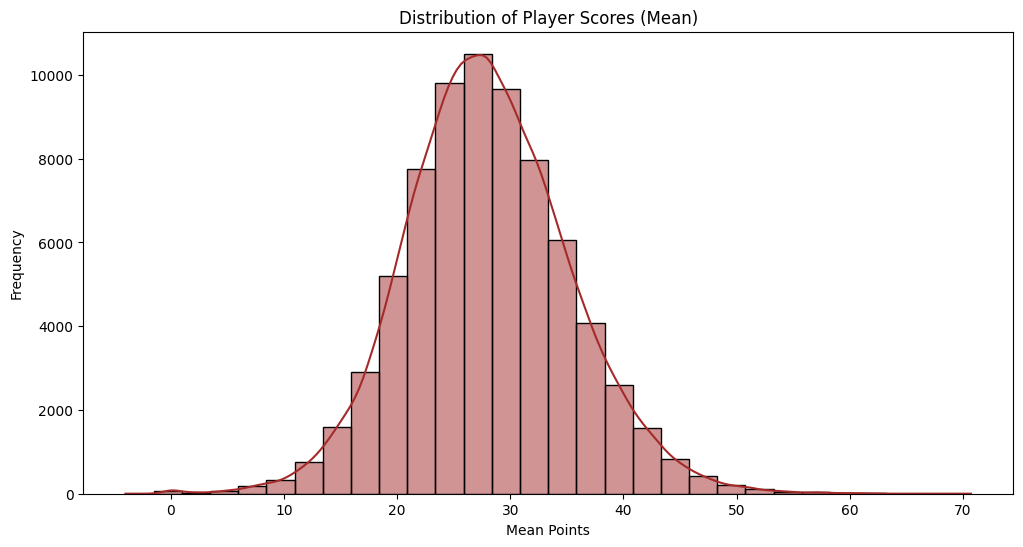

In [ ]:
# Distribution of player scores
plt.figure(figsize=(12, 6))
sns.histplot(turns_final['points_mean'], bins=30, kde=True, color='brown')
plt.title('Distribution of Player Scores (Mean)')
plt.xlabel('Mean Points')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Temporarily adding back bot_name column
turns_final['bot_name'] = turns_final[['nickname_against_BetterBot', 'nickname_against_HastyBot','nickname_against_STEEBot']].idxmax(axis=1)
def last_split(row):
  return row.split('_')[2]
turns_final['bot_name'] = turns_final['bot_name'].apply(last_split)
turns_final['bot_name']

0        BetterBot
1        BetterBot
2        BetterBot
3        BetterBot
4          STEEBot
           ...    
72758      STEEBot
72759     HastyBot
72760     HastyBot
72761    BetterBot
72762     HastyBot
Name: bot_name, Length: 72763, dtype: object

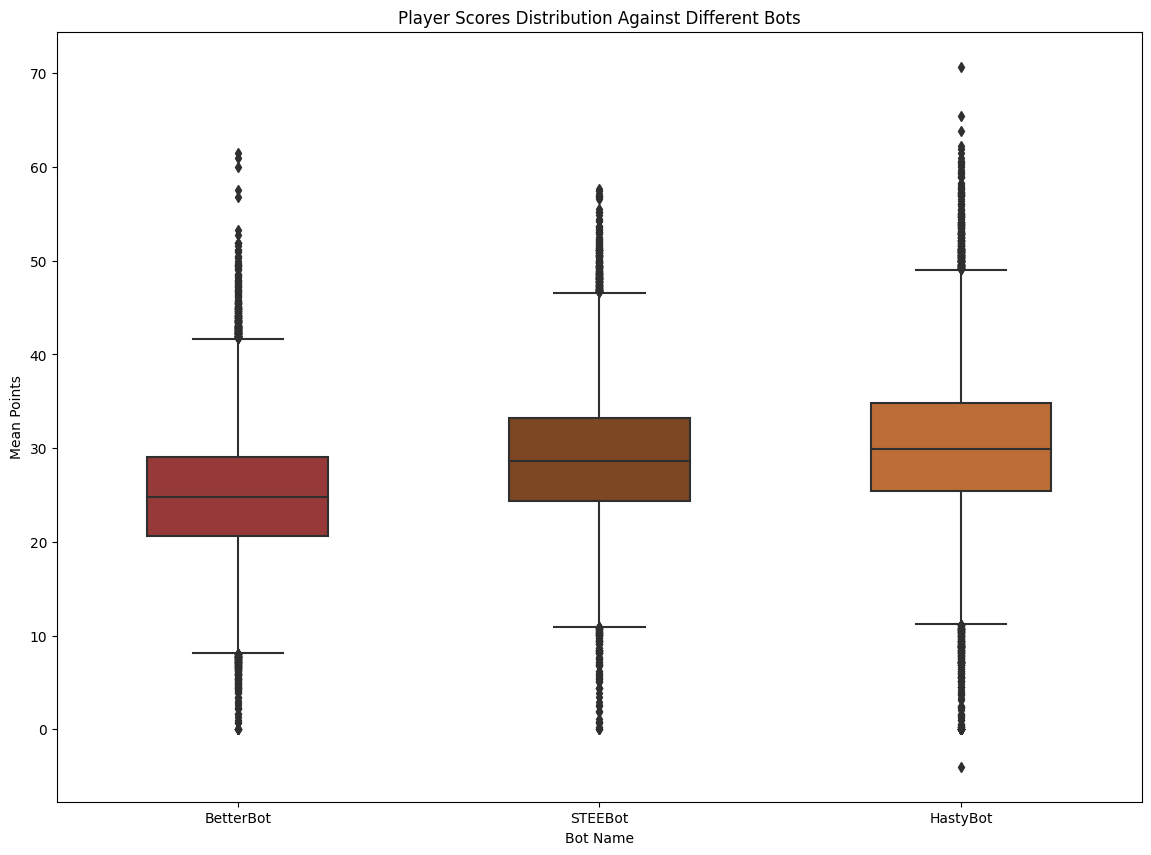

In [ ]:
# Boxplot of player scores against different opponents
bot_colors = {'#D2691E', '#8B4513', '#A52A2A'}

plt.figure(figsize=(14, 10))
sns.boxplot(x='bot_name', y='points_mean', data=turns_final, width=0.5,palette=bot_colors)
plt.title('Player Scores Distribution Against Different Bots')
plt.xlabel('Bot Name')
plt.ylabel('Mean Points')
plt.show()


##2.02 - Distributions of Turn Types

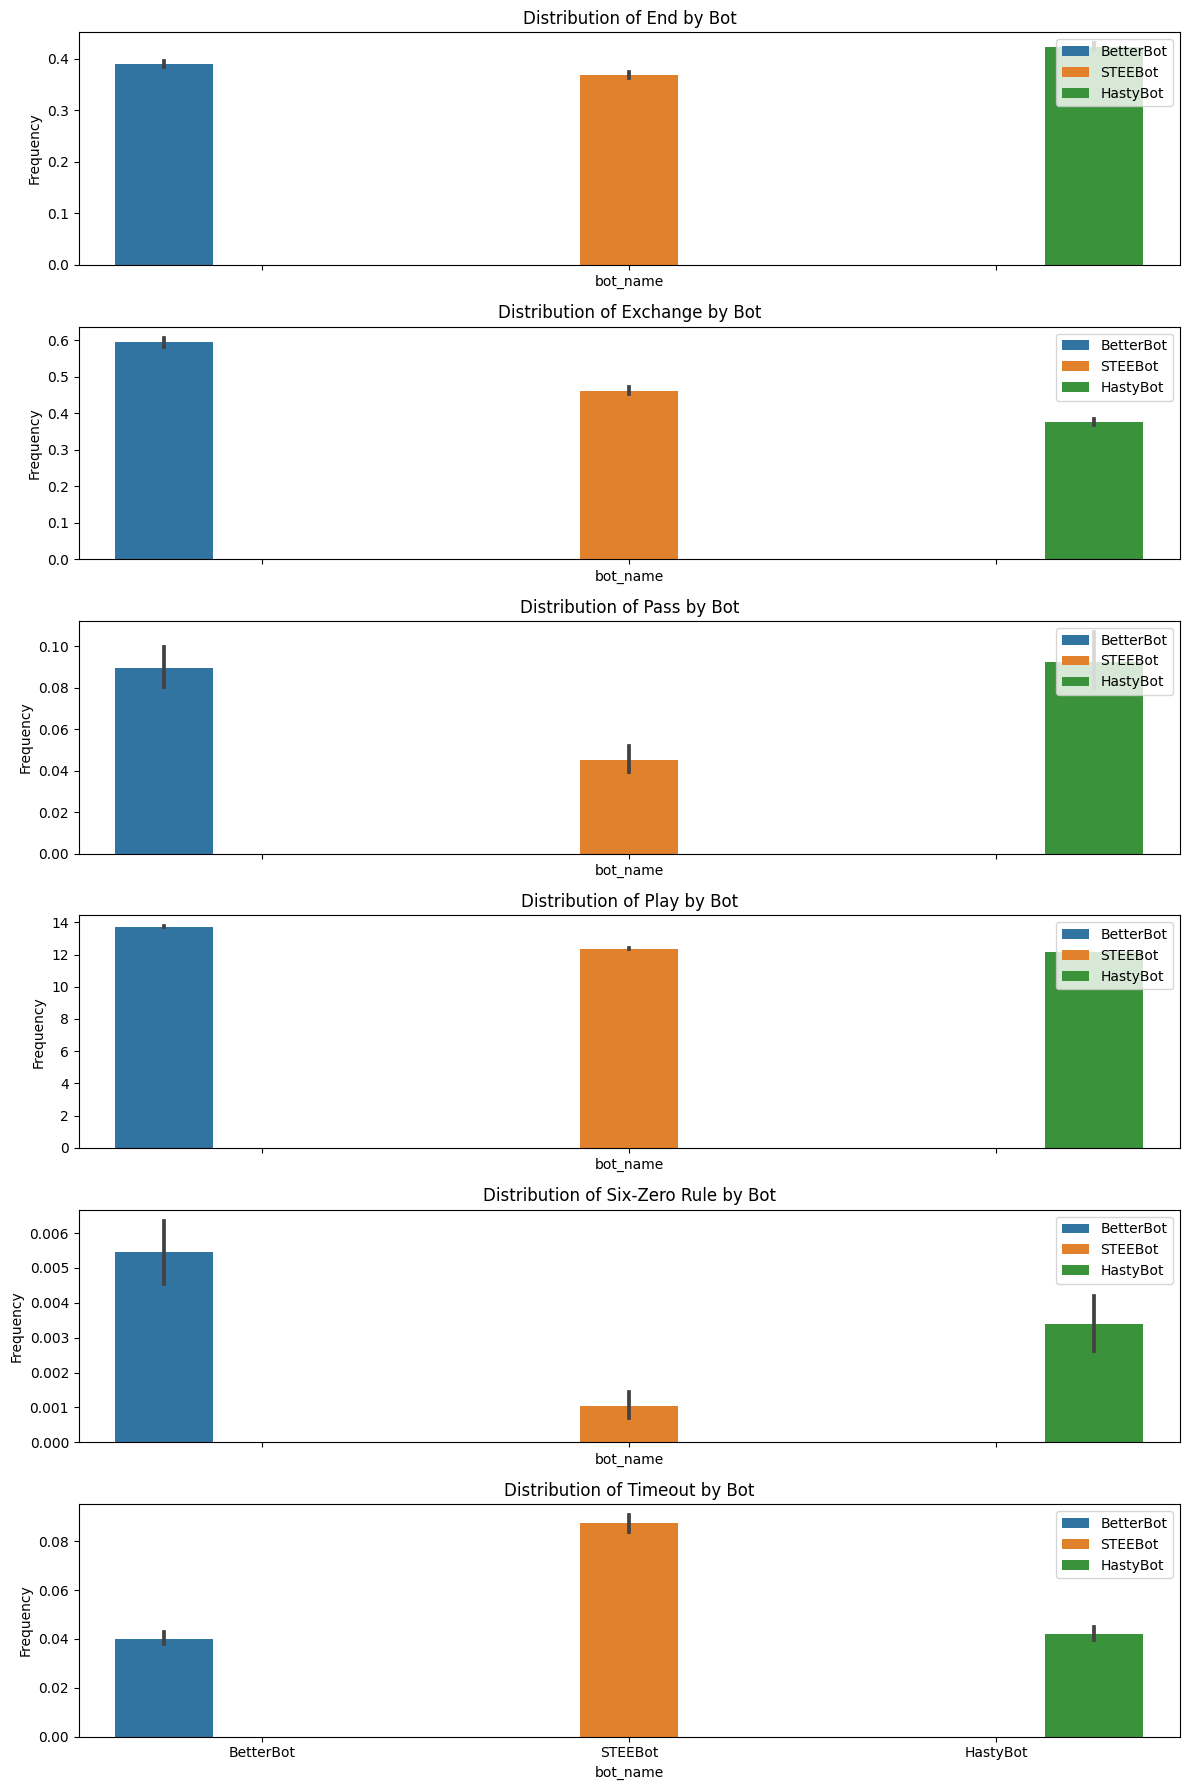

In [ ]:
#Revised version with legends on each of the subplots
turn_type_columns = ['End', 'Exchange', 'Pass', 'Play', 'Six-Zero Rule', 'Timeout']

# Set up the subplots
fig, axes = plt.subplots(nrows=len(turn_type_columns), ncols=1, figsize=(12, 18), sharex=True)

# Reshape data for plotting
melted_data = turns_final.melt(id_vars='bot_name', value_vars=turn_type_columns, var_name='turn_type', value_name='value')

# Create bar plots for each turn type
for i, turn_type in enumerate(turn_type_columns):
    # Filter data for each turn type
    filtered_data = melted_data[melted_data['turn_type'] == turn_type]

    # Use 'hue' for labeling
    sns.barplot(x='bot_name', y='value', hue='bot_name', data=filtered_data, ax=axes[i])
    axes[i].set_title(f'Distribution of {turn_type} by Bot')
    axes[i].set_ylabel('Frequency')

    # Add legend to each subplot
    axes[i].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
turns_final.drop('bot_name', inplace=True, axis=1)

##2.03 - Distribution of Move Types




In [ ]:
turns_raw.head()

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type,bot
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play,True
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play,False
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play,True
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play,False
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play,True


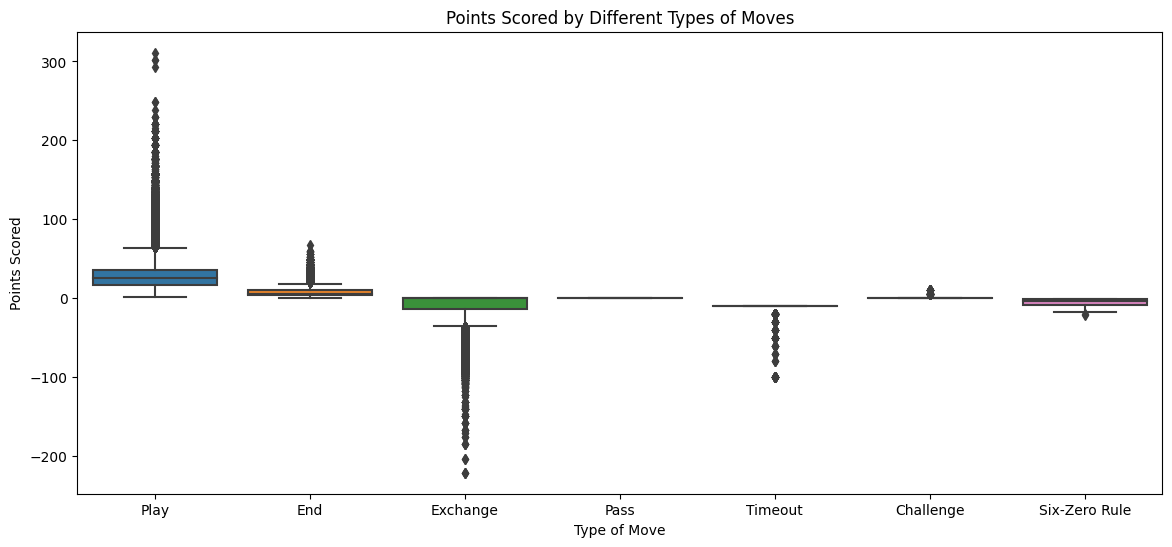

Play             1872864
End                67987
Exchange           48997
Pass                8065
Timeout             4143
Challenge           2571
Six-Zero Rule        476
Name: turn_type, dtype: int64

In [ ]:
# Distribution of different move types using value_counts
move_types_counts = turns_raw['turn_type'].value_counts()

plt.figure(figsize=(14, 6))

# Boxplot for Points Scored by Turn Type
sns.boxplot(x='turn_type', y='points', data=turns_raw)
plt.title('Points Scored by Different Types of Moves')
plt.xlabel('Type of Move')
plt.ylabel('Points Scored')
plt.show()

move_types_counts

##2.04 - Outlier Detectors

In [ ]:
# detect outlier with percentile
def detect_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    # interquartile range
    iqr = q3 - q1

    # set up 1.5 bound for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

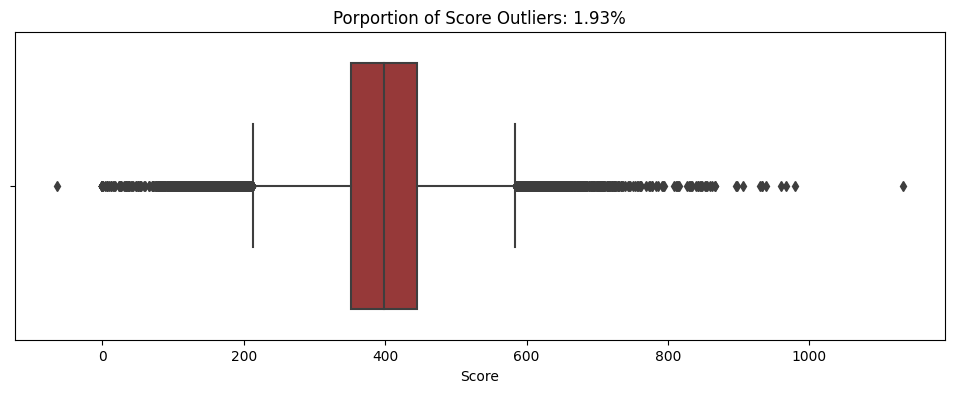

Numbers of outliers: 1944
Numbers of non-outliers: 98876


In [ ]:
# detect score outlier
points_mean = np.array(train_raw['score'])
outliers = detect_outliers(points_mean)

# the number of outliers and non-outliers
num_outliers = np.sum(outliers)
num_non_outliers = len(points_mean) - num_outliers

# the proportion of outliers
proportion_outliers = num_outliers / len(points_mean)

plt.figure(figsize=(12, 4))
sns.boxplot(x=points_mean, color='brown')
plt.title(f'Porportion of Score Outliers: {proportion_outliers:.2%}')
plt.xlabel('Score')
plt.show()

print('Numbers of outliers:', num_outliers)
print('Numbers of non-outliers:', num_non_outliers)

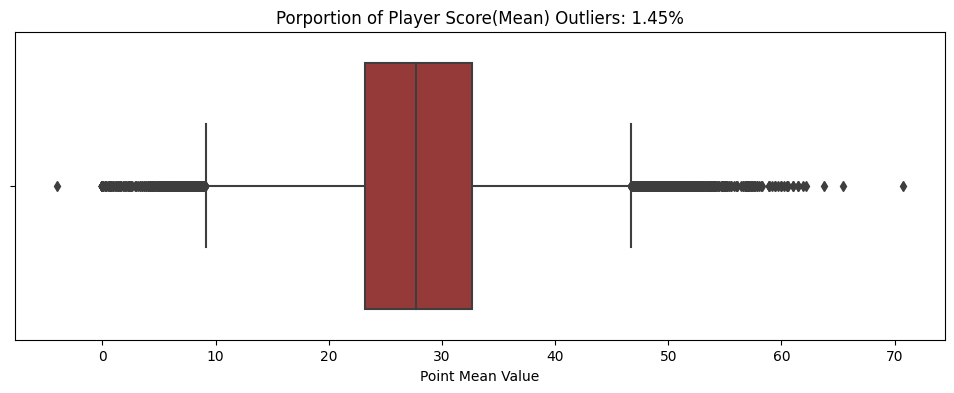

In [ ]:
# detect Player Score(Mean) Outliers outlier
points_mean = np.array(turns_final['points_mean'])
outliers = detect_outliers(points_mean)

# the number of outliers and non-outliers
num_outliers = np.sum(outliers)
num_non_outliers = len(points_mean) - num_outliers

# the proportion of outliers
proportion_outliers = num_outliers / len(points_mean)

plt.figure(figsize=(12, 4))
sns.boxplot(x=points_mean, color='brown')
plt.title(f'Porportion of Player Score(Mean) Outliers: {proportion_outliers:.2%}')
plt.xlabel('Point Mean Value')
plt.show()

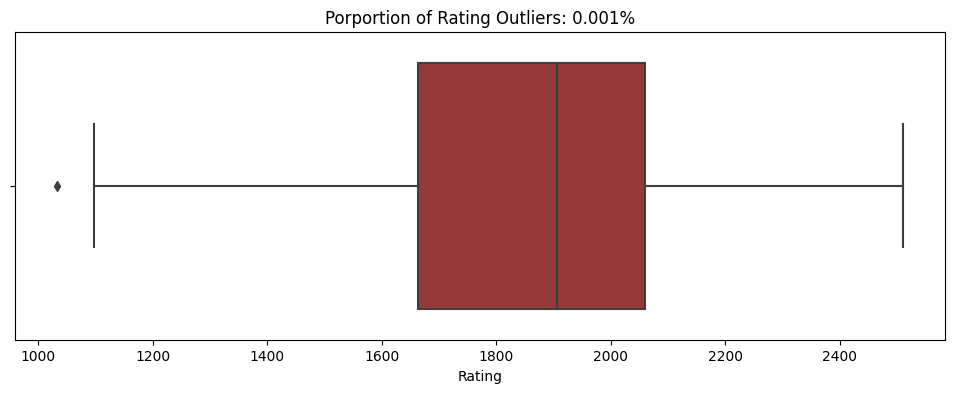

In [ ]:
# detect Rating outlier
points_mean = np.array(train_raw['rating'])
outliers = detect_outliers(points_mean)

# the number of outliers and non-outliers
num_outliers = np.sum(outliers)
num_non_outliers = len(points_mean) - num_outliers

# the proportion of outliers
proportion_outliers = num_outliers / len(points_mean)

plt.figure(figsize=(12, 4))
sns.boxplot(x=points_mean, color='brown')
plt.title(f'Porportion of Rating Outliers: {proportion_outliers:.3%}')
plt.xlabel('Rating')
plt.show()

In [ ]:
# detect points mean outlier
def outlier_proportion(column):
    points_mean = np.array(column)
    outliers = detect_outliers(points_mean)

    # the number of outliers and non-outliers
    num_outliers = np.sum(outliers)
    num_non_outliers = len(points_mean) - num_outliers

    # the proportion of outliers
    proportion_outliers = num_outliers / len(points_mean)
    return proportion_outliers

In [ ]:
# for those columns that have outliers more than 5% in the turns_final dataset
for col in turns_final.columns:
    if turns_final[col].dtype in [np.float64, np.int64]:
        proportion_outliers = outlier_proportion(turns_final[col])

        # Only report columns with a proportion of outliers greater than 0
        if proportion_outliers > 0.05:
            print(f'{col}: Proportion of outliers - {proportion_outliers:.2%}')

points_min: Proportion of outliers - 12.51%
points_max: Proportion of outliers - 12.25%
points_max_against: Proportion of outliers - 7.90%
Timeout: Proportion of outliers - 5.69%
points_player_all_games_count: Proportion of outliers - 15.74%
points_count_diff_self: Proportion of outliers - 15.74%
points_min_diff_bot: Proportion of outliers - 9.58%
points_min_last_1_games: Proportion of outliers - 12.51%
points_max_last_1_games: Proportion of outliers - 12.25%
points_min_last_5_games: Proportion of outliers - 14.95%
points_max_last_5_games: Proportion of outliers - 13.71%
points_sum_last_5_games: Proportion of outliers - 6.28%
points_max_last_10_games: Proportion of outliers - 13.67%
points_sum_last_10_games: Proportion of outliers - 10.01%
points_std_last_20_games: Proportion of outliers - 5.40%
points_sum_last_20_games: Proportion of outliers - 14.45%


In [ ]:
# for those columns that have outliers more than 5% in the train_raw dataset
for col in train_raw.columns:
    if train_raw[col].dtype in [np.float64, np.int64]:
        proportion_outliers = outlier_proportion(train_raw[col])

        # Only report columns with a proportion of outliers greater than 0
        if proportion_outliers > 0.05:
            print(f'{col}: Proportion of outliers - {proportion_outliers:.2%}')
    else:
      print(None)

None


In [ ]:
for col in turns_raw.columns:
    if turns_raw[col].dtype in [np.float64, np.int64]:
        proportion_outliers = outlier_proportion(turns_raw[col])

        # Only report columns with a proportion of outliers greater than 0
        if proportion_outliers > 0.05:
            print(f'{col}: Proportion of outliers - {proportion_outliers:.2%}')

points: Proportion of outliers - 10.59%


##2.05 - Overall Visualizations

In [ ]:
# Visualizing Scores and Ratings

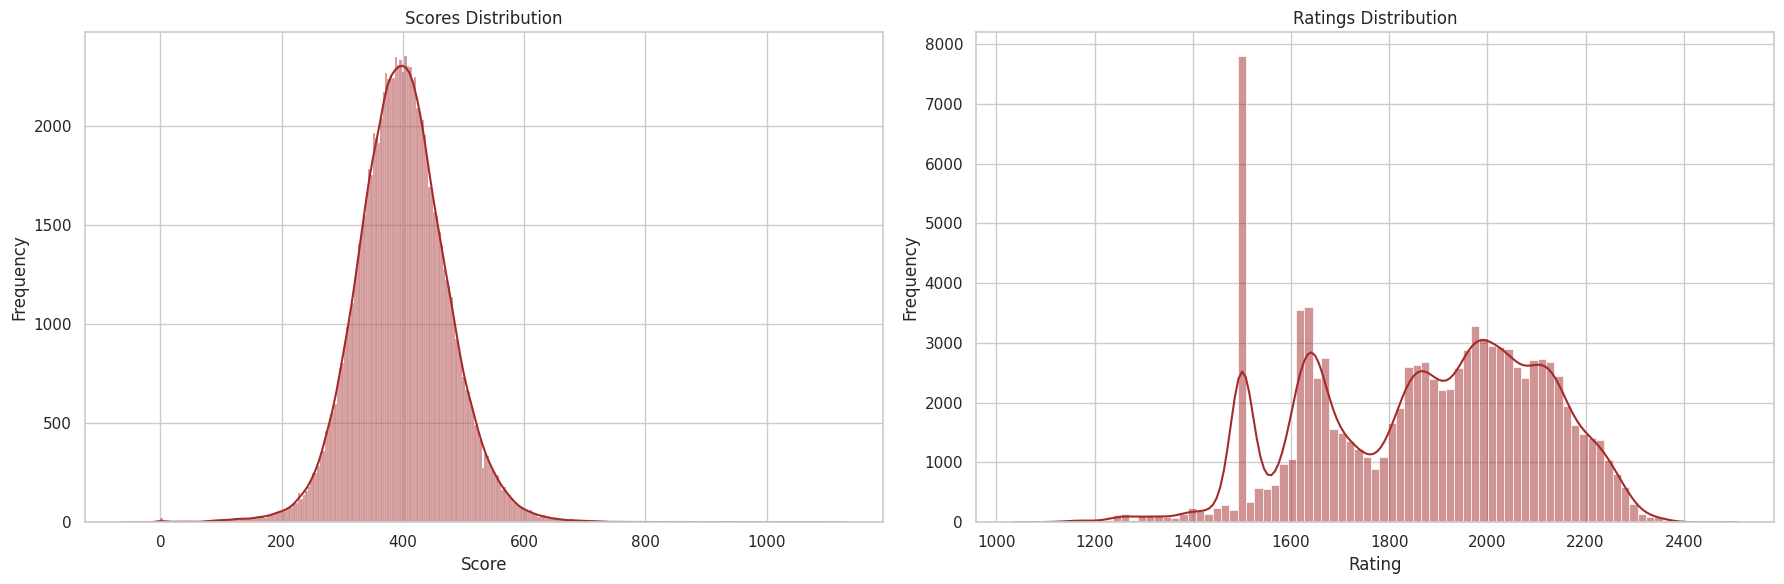

In [ ]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Score distribution
sns.histplot(train_raw['score'], kde=True, ax=ax[0], color='brown')
ax[0].set_title('Scores Distribution')
ax[0].set_xlabel('Score')
ax[0].set_ylabel('Frequency')

# Rating distribution
sns.histplot(train_raw['rating'], kde=True, ax=ax[1], color='brown')
ax[1].set_title('Ratings Distribution')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Visualize how many games players are playing

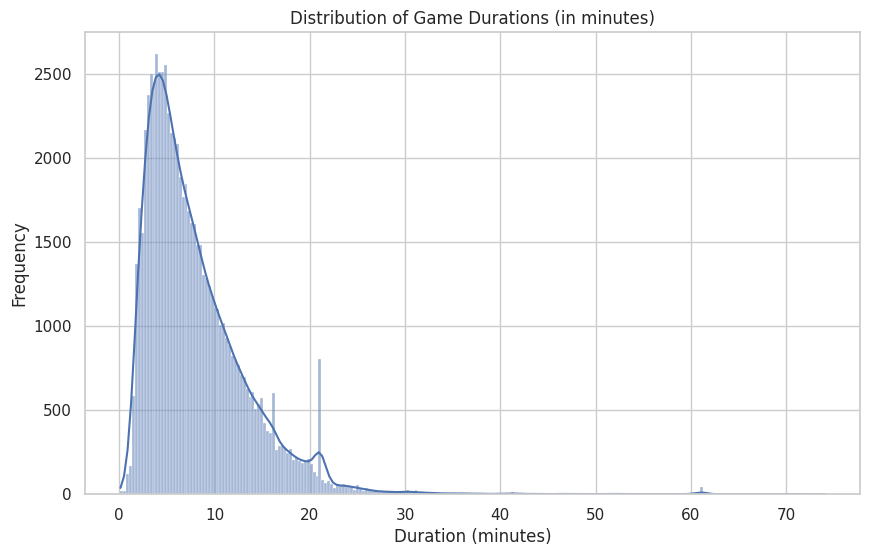

In [ ]:
# Convert 'game_duration_seconds' to minutes
games_raw['game_duration_minutes'] = games_raw['game_duration_seconds'] / 60

# Game duration distribution
plt.figure(figsize=(10, 6))
sns.histplot(games_raw['game_duration_minutes'], kde=True)
plt.title('Distribution of Game Durations (in minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

#3.x Feature Engineering

##3.01: Generate New Features

In [ ]:
games = pd.read_csv('/content/kaggle/games.csv')

For the turns level data we want to create a more comprehensive overview of game play, to do so we:
<br>
- One hot encode the 'turn_type' column
- Create a 'tiles_placed' feature that calculates the amount of letters added to the board for that turn from the user. This is easily calculated from our existing 'move' column, by simply removing the '.' from the move (the '.' represents existing letters on the board).
- Create a 'rare_letters' feature. We want to give an additional level of acknowledgment to moves that use tough letters. We define these tough letters as "Z", "Q", "J", "X", "K", "V", "Y", "W", and "G."
- Create a 'points_per_tile_placed' feature, which just takes the points feature and divides it by our newly defined 'tiles_placed' feature.
- Create 10 percentile wide categories for that turn's score. Using the overall distribution of points for all 2 million + turns, each turn is placed into one of these 10 percentile wide category, therefore, each category is binary (0 or 1).
- Create a 'horizontal_placement' column. As we start to grasp a better understanding of the data set we came to realize that turns that started with a number were placed horizontally on the board. We add a binary variable to grasp an understanding of the direction the word is played.

In [ ]:
turns = pd.read_csv('/content/kaggle/turns.csv')
dummies = pd.get_dummies(turns['turn_type'], prefix='turn_type')
turns = pd.concat([turns, dummies], axis = 1)
turns = turns.drop('turn_type', axis = 1)
turns['tiles_placed'] = turns['move'].apply(lambda x: len(str(x).replace('.', '')))
rare_letters = ["Z", "Q", "J", "X", "K", "V", "Y", "W", "G"]
turns["difficult_letters"] = turns["move"].apply(lambda x: len([letter for letter in str(x) if letter in rare_letters]))
turns['points_per_tile_placed'] = turns['points'] / turns['tiles_placed']
turns['0_10_percentile'] = np.where(turns['points'] < turns['points'].quantile(0.1), 1, 0)
turns['10_20_percentile'] = np.where((turns['points'] >= turns['points'].quantile(0.1)) & (turns['points'] < turns['points'].quantile(0.2)), 1, 0)
turns['20_30_percentile'] = np.where((turns['points'] >= turns['points'].quantile(0.2)) & (turns['points'] < turns['points'].quantile(0.3)), 1, 0)
turns['30_40_percentile'] = np.where((turns['points'] >= turns['points'].quantile(0.3)) & (turns['points'] < turns['points'].quantile(0.4)), 1, 0)
turns['40_50_percentile'] = np.where((turns['points'] >= turns['points'].quantile(0.4)) & (turns['points'] < turns['points'].quantile(0.5)), 1, 0)
turns['50_60_percentile'] = np.where((turns['points'] >= turns['points'].quantile(0.5)) & (turns['points'] < turns['points'].quantile(0.6)), 1, 0)
turns['60_70_percentile'] = np.where((turns['points'] >= turns['points'].quantile(0.6)) & (turns['points'] < turns['points'].quantile(0.7)), 1, 0)
turns['70_80_percentile'] = np.where((turns['points'] >= turns['points'].quantile(0.7)) & (turns['points'] < turns['points'].quantile(0.8)), 1, 0)
turns['80_90_percentile'] = np.where((turns['points'] >= turns['points'].quantile(0.8)) & (turns['points'] < turns['points'].quantile(0.9)), 1, 0)
turns['90_100_percentile'] = np.where((turns['points'] >= turns['points'].quantile(0.9)), 1, 0)
turns['horizontal_placement'] = turns['location'].apply(lambda x : int(str(x)[0].isdigit()))

In [ ]:
train = pd.read_csv('/content/kaggle/train.csv')
test = pd.read_csv('/content/kaggle/test.csv')
train = pd.concat([test, train])

In [ ]:
train

,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN
4,11,STEEBot,334,1829.0
...,...,...,...,...
100815,72771,HastyBot,393,1614.0
100816,72772,BetterBot,442,1674.0
100817,72772,Gtowngrad,388,1364.0
100818,72773,adola,383,2075.0


Merge the train data that we are given that includes valuable information about what the bot and human were rated coming into the game with the game level data. This pregame rating is eventually going to be our target variable in our prediction:

In [ ]:
full_data = train.merge(games, on = 'game_id')

We want to split the bots and human players apart so that we are able to focus on creating human level features and bot level features and then merge them back together after doing so into one dataset.

In [ ]:
nicknames = ('STEEBot', 'BetterBot', 'HastyBot')

bots_full = full_data[full_data['nickname'].isin(nicknames)][['game_id', 'nickname', 'score', 'rating']]
bots_full.columns = ['game_id', 'bot_name', 'bot_score', 'bot_rating']

In [ ]:
non_bots = full_data[~full_data['nickname'].isin(nicknames)]
full_data = non_bots.merge(bots_full, on = 'game_id')
full_data.head()

,game_id,nickname,score,rating,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,bot_name,bot_score,bot_rating
0,2,Super,488,NaN,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418,BetterBot,401,2000.0
1,7,Priya1,379,NaN,Priya1,regular,STANDARD,1,2022-08-26 03:07:48,CSW21,1260,0,RATED,1,385.599607,STEEBot,377,2082.0
2,11,TileRunner,462,NaN,TileRunner,regular,STANDARD,1,2022-08-22 01:13:10,NWL20,1200,0,CASUAL,1,501.739156,STEEBot,334,1829.0
3,14,Anfield223,359,NaN,STEEBot,regular,STANDARD,0,2022-09-14 14:06:24,CSW21,900,0,RATED,1,293.253051,STEEBot,403,2136.0
4,27,friesbasil,456,NaN,friesbasil,regular,STANDARD,1,2022-09-13 09:12:15,CSW21,1200,0,RATED,1,203.963230,HastyBot,453,2258.0


Returning back to our turn level data, we want to create aggregate this data set to have each row represent 1 single game. The logic behind this is so that we are able to combine it seamlessly with the game level data. To do so, we take a variety of statistics for each feature, by grouping by each game and within that game we take the following statistics for each feature:
<br>
- Points:
 - Mean
 - Max
 - Variance
 - Min
- Turn_Number:
 - Count
    - This represents the total number of turns played by the user for that game
- Turn_Type:
 - Sum
    - Since Turn_Type is a binary variable, this represents the total number of that turn type played in that game
 - Mean
    - Again, due to Turn_Type being binary, this represents the proportion of turns for that game that were this specific turn type.
- Tiles_Placed:
 - Mean
 - Variance
 - Max
 - Min
- Difficult Letters:
 - Sum
    - Represents the total number of difficult letters used in the game
 - Mean
    - Represent the average amount of difficult letters played per turn in the game
- Points Placed per Tile:
 - Mean
 - Max
 - Min
 - Variance
- Percentile Categories:
  - Mean
    - Since these columns are all binary, this represents the proportion of turns in the game that were in this percenitle category.
  - Sum
    - This represents the total number of turns that fell into this percentile category in the game.
- Horizontal Placement:
  - Sum
    - This represents the total number of horizontal words placed in the game.

In [ ]:
turns_agg = turns.groupby(['game_id', 'nickname']).agg({
    'points': [('points_mean', 'mean'), ('points_max', 'max'), ('points_var', 'var'), ('points_min', 'min')],
    'turn_number': 'count',
    'score': 'max',
    'turn_type_Challenge': [('turn_type_Challenge_sum', 'sum'), ('turn_type_Challenge_mean', 'mean')],
    'turn_type_End': [('turn_type_End_sum', 'sum'), ('turn_type_End_mean', 'mean')],
    'turn_type_Exchange': [('turn_type_Exchange_sum', 'sum'), ('turn_type_Exchange_mean', 'mean')],
    'turn_type_Pass': [('turn_type_Pass_sum', 'sum'), ('turn_type_Pass_mean', 'mean')],
    'turn_type_Play': [('turn_type_Play_sum', 'sum'), ('turn_type_Play_mean', 'mean')],
    'turn_type_Six-Zero Rule': [('turn_type_Six-Zero Rule_sum', 'sum'), ('turn_type_Six-Zero Rule_mean', 'mean')],
    'turn_type_Timeout': [('turn_type_Timeout_sum', 'sum'), ('turn_type_Timeout_mean', 'mean')],
    'tiles_placed': [('tiles_placed_mean', 'mean'), ('tiles_placed_var', 'var'), ('tiles_placed_max', 'max'), ('tiles_placed_min', 'min')],
    'difficult_letters': [('difficult_letters_sum', 'sum'), ('difficult_letters_mean', 'mean')],
    'points_per_tile_placed' : [('points_per_tile_placed_mean', 'mean'), ('points_per_tile_placed_max', 'max'), ('points_per_tile_placed_min', 'min'), ('points_per_tile_placed_var', 'var')],
    '0_10_percentile' : [('0_10_percentile_mean', 'mean'), ('0_10_percentile_sum', 'sum')],
    '10_20_percentile' : [('10_20_percentile_mean', 'mean'), ('10_20_percentile_sum', 'sum')],
    '20_30_percentile' : [('20_30_percentile_mean', 'mean'), ('20_30_percentile_sum', 'sum')],
    '30_40_percentile' : [('30_40_percentile_mean', 'mean'), ('30_40_percentile_sum', 'sum')],
    '40_50_percentile' : [('40_50_percentile_mean', 'mean'), ('40_50_percentile_sum', 'sum')],
    '50_60_percentile' : [('50_60_percentile_mean', 'mean'), ('50_60_percentile_sum', 'sum')],
    '60_70_percentile' : [('60_70_percentile_mean', 'mean'), ('60_70_percentile_sum', 'sum')],
    '70_80_percentile' : [('70_80_percentile_mean', 'mean'), ('70_80_percentile_sum', 'sum')],
    '80_90_percentile' : [('80_90_percentile_mean', 'mean'), ('80_90_percentile_sum', 'sum')],
    '90_100_percentile' : [('90_100_percentile_mean', 'mean'), ('90_100_percentile_sum', 'sum')],
    'horizontal_placement' : 'sum'
})

turns_agg.columns = ['_'.join(col).strip() for col in turns_agg.columns.values]

all_turns_agg = turns_agg.reset_index()

Next, we split the bots and humans apart into two distinct datasets at the turn level. The reasoning behind this is that each games turn is on a seperate line. As, such the typical order of turns goes Bot, Human, Bot, Human.... We want to have the data condensed so that each game is 1 line. To do so we need to have the bots turn data and the players turn data in the same line next to each other: **bold text**

In [ ]:
bots_turns = all_turns_agg[all_turns_agg['nickname'].isin(nicknames)]
bots_turns.columns = ['game_id', 'bot_nickname', 'bot_points_points_mean', 'bot_points_points_max',
                      'bot_points_points_var', 'bot_points_points_min', 'bot_turn_number_count', 'bot_score_max',
                      'bot_turn_type_Challenge_turn_type_Challenge_sum', 'bot_turn_type_Challenge_turn_type_Challenge_mean',
                      'bot_turn_type_End_turn_type_End_sum', 'bot_turn_type_End_turn_type_End_mean',
                      'bot_turn_type_Exchange_turn_type_Exchange_sum', 'bot_turn_type_Exchange_turn_type_Exchange_mean',
                      'bot_turn_type_Pass_turn_type_Pass_sum', 'bot_turn_type_Pass_turn_type_Pass_mean',
                      'bot_turn_type_Play_turn_type_Play_sum', 'bot_turn_type_Play_turn_type_Play_mean',
                      'bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum',
                      'bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean',
                      'bot_turn_type_Timeout_turn_type_Timeout_sum', 'bot_turn_type_Timeout_turn_type_Timeout_mean',
                      'bot_tiles_placed_tiles_placed_mean', 'bot_tiles_placed_tiles_placed_var',
                      'bot_tiles_placed_tiles_placed_max', 'bot_tiles_placed_tiles_placed_min',
                      'bot_difficult_letters_difficult_letters_sum', 'bot_difficult_letters_difficult_letters_mean',
                      'bot_points_per_tile_placed_points_per_tile_placed_mean',
                      'bot_points_per_tile_placed_points_per_tile_placed_max',
                      'bot_points_per_tile_placed_points_per_tile_placed_min',
                      'bot_points_per_tile_placed_points_per_tile_placed_var',
                      'bot_0_10_percentile_0_10_percentile_mean', 'bot_0_10_percentile_0_10_percentile_sum',
                      'bot_10_20_percentile_10_20_percentile_mean', 'bot_10_20_percentile_10_20_percentile_sum',
                      'bot_20_30_percentile_20_30_percentile_mean', 'bot_20_30_percentile_20_30_percentile_sum',
                      'bot_30_40_percentile_30_40_percentile_mean', 'bot_30_40_percentile_30_40_percentile_sum',
                      'bot_40_50_percentile_40_50_percentile_mean', 'bot_40_50_percentile_40_50_percentile_sum',
                      'bot_50_60_percentile_50_60_percentile_mean', 'bot_50_60_percentile_50_60_percentile_sum',
                      'bot_60_70_percentile_60_70_percentile_mean', 'bot_60_70_percentile_60_70_percentile_sum',
                      'bot_70_80_percentile_70_80_percentile_mean', 'bot_70_80_percentile_70_80_percentile_sum',
                      'bot_80_90_percentile_80_90_percentile_mean', 'bot_80_90_percentile_80_90_percentile_sum',
                      'bot_90_100_percentile_90_100_percentile_mean', 'bot_90_100_percentile_90_100_percentile_sum',
                      'bot_horizontal_placement_sum']
bots_turns.drop('bot_nickname', axis = 1, inplace = True)
bots_turns.head()

<ipython-input-76-02ca2d6846aa>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bots_turns.drop('bot_nickname', axis = 1, inplace = True)


,game_id,bot_points_points_mean,bot_points_points_max,bot_points_points_var,bot_points_points_min,bot_turn_number_count,bot_score_max,bot_turn_type_Challenge_turn_type_Challenge_sum,bot_turn_type_Challenge_turn_type_Challenge_mean,bot_turn_type_End_turn_type_End_sum,...,bot_50_60_percentile_50_60_percentile_sum,bot_60_70_percentile_60_70_percentile_mean,bot_60_70_percentile_60_70_percentile_sum,bot_70_80_percentile_70_80_percentile_mean,bot_70_80_percentile_70_80_percentile_sum,bot_80_90_percentile_80_90_percentile_mean,bot_80_90_percentile_80_90_percentile_sum,bot_90_100_percentile_90_100_percentile_mean,bot_90_100_percentile_90_100_percentile_sum,bot_horizontal_placement_sum
0,1,25.769231,68,270.858974,8,13,335,0,0.0,0,...,2,0.230769,3,0.000000,0,0.076923,1,0.076923,1,2.0
2,2,33.416667,85,653.537879,8,12,401,0,0.0,0,...,2,0.000000,0,0.083333,1,0.083333,1,0.166667,2,0.0
4,3,24.461538,76,326.102564,0,13,318,0,0.0,0,...,0,0.153846,2,0.076923,1,0.000000,0,0.076923,1,0.0
6,4,31.866667,74,438.695238,8,15,478,0,0.0,0,...,2,0.066667,1,0.133333,2,0.133333,2,0.133333,2,0.0
8,5,28.466667,81,413.980952,14,15,427,0,0.0,0,...,3,0.066667,1,0.000000,0,0.000000,0,0.133333,2,0.0


In [ ]:
non_bots_turns = all_turns_agg[~all_turns_agg['nickname'].isin(nicknames)]
non_bots_turns.columns = ['game_id', 'nickname', 'points_points_mean', 'points_points_max', 'points_points_var',
                          'points_points_min', 'turn_number_count', 'score_max',
                          'turn_type_Challenge_turn_type_Challenge_sum', 'turn_type_Challenge_turn_type_Challenge_mean',
                          'turn_type_End_turn_type_End_sum', 'turn_type_End_turn_type_End_mean',
                          'turn_type_Exchange_turn_type_Exchange_sum', 'turn_type_Exchange_turn_type_Exchange_mean',
                          'turn_type_Pass_turn_type_Pass_sum', 'turn_type_Pass_turn_type_Pass_mean',
                          'turn_type_Play_turn_type_Play_sum', 'turn_type_Play_turn_type_Play_mean',
                          'turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum',
                          'turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean',
                          'turn_type_Timeout_turn_type_Timeout_sum', 'turn_type_Timeout_turn_type_Timeout_mean',
                          'tiles_placed_tiles_placed_mean', 'tiles_placed_tiles_placed_var',
                          'tiles_placed_tiles_placed_max', 'tiles_placed_tiles_placed_min',
                          'difficult_letters_difficult_letters_sum', 'difficult_letters_difficult_letters_mean',
                          'points_per_tile_placed_points_per_tile_placed_mean',
                          'points_per_tile_placed_points_per_tile_placed_max',
                          'points_per_tile_placed_points_per_tile_placed_min',
                          'points_per_tile_placed_points_per_tile_placed_var', '0_10_percentile_0_10_percentile_mean',
                          '0_10_percentile_0_10_percentile_sum', '10_20_percentile_10_20_percentile_mean',
                          '10_20_percentile_10_20_percentile_sum', '20_30_percentile_20_30_percentile_mean',
                          '20_30_percentile_20_30_percentile_sum', '30_40_percentile_30_40_percentile_mean',
                          '30_40_percentile_30_40_percentile_sum', '40_50_percentile_40_50_percentile_mean',
                          '40_50_percentile_40_50_percentile_sum', '50_60_percentile_50_60_percentile_mean',
                          '50_60_percentile_50_60_percentile_sum', '60_70_percentile_60_70_percentile_mean',
                          '60_70_percentile_60_70_percentile_sum', '70_80_percentile_70_80_percentile_mean',
                          '70_80_percentile_70_80_percentile_sum', '80_90_percentile_80_90_percentile_mean',
                          '80_90_percentile_80_90_percentile_sum', '90_100_percentile_90_100_percentile_mean',
                          '90_100_percentile_90_100_percentile_sum', 'horizontal_placement_sum']
non_bots_turns.drop('nickname', axis = 1, inplace = True)

<ipython-input-77-4ff63005dc0f>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_bots_turns.drop('nickname', axis = 1, inplace = True)


,game_id,points_points_mean,points_points_max,points_points_var,points_points_min,turn_number_count,score_max,turn_type_Challenge_turn_type_Challenge_sum,turn_type_Challenge_turn_type_Challenge_mean,turn_type_End_turn_type_End_sum,...,bot_50_60_percentile_50_60_percentile_sum,bot_60_70_percentile_60_70_percentile_mean,bot_60_70_percentile_60_70_percentile_sum,bot_70_80_percentile_70_80_percentile_mean,bot_70_80_percentile_70_80_percentile_sum,bot_80_90_percentile_80_90_percentile_mean,bot_80_90_percentile_80_90_percentile_sum,bot_90_100_percentile_90_100_percentile_mean,bot_90_100_percentile_90_100_percentile_sum,bot_horizontal_placement_sum
0,1,30.642857,98,649.785714,2,14,429,0,0.0,1,...,2,0.230769,3,0.000000,0,0.076923,1,0.076923,1,2.0
1,2,34.857143,94,952.747253,0,14,488,0,0.0,1,...,2,0.000000,0,0.083333,1,0.083333,1,0.166667,2,0.0
2,3,31.428571,103,470.417582,13,14,440,0,0.0,1,...,0,0.153846,2,0.076923,1,0.000000,0,0.076923,1,0.0
3,4,8.500000,26,73.961538,0,14,119,0,0.0,0,...,2,0.066667,1,0.133333,2,0.133333,2,0.133333,2,0.0
4,5,20.312500,51,154.895833,0,16,325,0,0.0,1,...,3,0.066667,1,0.000000,0,0.000000,0,0.133333,2,0.0


As mentioned, we now merge the human turn level data and the bots turn level data so that they are all in one row where each row represents an individual game:

In [ ]:
full_turns = non_bots_turns.merge(bots_turns, on = 'game_id')
full_turns.head()

Now that our turn-level data has been aggregated to be on the same level as the game level data, we can merge the aggregated turn level data with our original game level data:

In [ ]:
full_df = full_data.merge(full_turns, on = 'game_id')
full_df.head()

,game_id,nickname,score,rating,first,time_control_name,game_end_reason,winner,created_at,lexicon,...,bot_50_60_percentile_50_60_percentile_sum,bot_60_70_percentile_60_70_percentile_mean,bot_60_70_percentile_60_70_percentile_sum,bot_70_80_percentile_70_80_percentile_mean,bot_70_80_percentile_70_80_percentile_sum,bot_80_90_percentile_80_90_percentile_mean,bot_80_90_percentile_80_90_percentile_sum,bot_90_100_percentile_90_100_percentile_mean,bot_90_100_percentile_90_100_percentile_sum,bot_horizontal_placement_sum
0,2,Super,488,NaN,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,...,2,0.000000,0,0.083333,1,0.083333,1,0.166667,2,0.0
1,7,Priya1,379,NaN,Priya1,regular,STANDARD,1,2022-08-26 03:07:48,CSW21,...,1,0.142857,2,0.000000,0,0.214286,3,0.000000,0,0.0
2,11,TileRunner,462,NaN,TileRunner,regular,STANDARD,1,2022-08-22 01:13:10,NWL20,...,1,0.133333,2,0.000000,0,0.066667,1,0.066667,1,0.0
3,14,Anfield223,359,NaN,STEEBot,regular,STANDARD,0,2022-09-14 14:06:24,CSW21,...,2,0.142857,2,0.214286,3,0.000000,0,0.071429,1,0.0
4,27,friesbasil,456,NaN,friesbasil,regular,STANDARD,1,2022-09-13 09:12:15,CSW21,...,1,0.000000,0,0.250000,3,0.333333,4,0.083333,1,0.0


Change the 'first' column, which indicates which player went first to a binary column. 1 if the human went first and 0 if the bot went first:

In [ ]:
full_df['first'] = np.where(full_df['first'] == full_df['nickname'], 1, 0)

One hot encode our categorical features from our original game level data:
- Time Control Name
- Game end reason
- Lexicon
- Rating Mode
- Bot name

In [ ]:
dummies = pd.get_dummies(full_df['time_control_name'], prefix='time_control_name')
full_df = pd.concat([full_df, dummies], axis = 1)
full_df = full_df.drop('time_control_name', axis = 1)

In [ ]:
dummies = pd.get_dummies(full_df['game_end_reason'], prefix='game_end_reason')
full_df = pd.concat([full_df, dummies], axis = 1)
full_df = full_df.drop('game_end_reason', axis = 1)

In [ ]:
dummies = pd.get_dummies(full_df['lexicon'], prefix='lexicon')
full_df = pd.concat([full_df, dummies], axis = 1)
full_df = full_df.drop('lexicon', axis = 1)

In [ ]:
dummies = pd.get_dummies(full_df['rating_mode'], prefix='rating_mode')
full_df = pd.concat([full_df, dummies], axis = 1)
full_df = full_df.drop('rating_mode', axis = 1)

In [ ]:
dummies = pd.get_dummies(full_df['bot_name'], prefix='bot_name')
full_df = pd.concat([full_df, dummies], axis = 1)
full_df = full_df.drop('bot_name', axis = 1)

Break up the data feature of the time the game was created at in to multiple time features:
- Year
- Month
- Day
- Hour
- Minute
- Second

We believe that by doing this, it will give us more detailed information about temporal habits of players.

In [ ]:
full_df['created_at'] = pd.to_datetime(full_df['created_at'])
full_df['year'] = full_df['created_at'].dt.year
full_df['month'] = full_df['created_at'].dt.month
full_df['day'] = full_df['created_at'].dt.day
full_df['hour'] = full_df['created_at'].dt.hour
full_df['minute'] = full_df['created_at'].dt.minute
full_df['seconds'] = full_df['created_at'].dt.second
full_df = full_df.drop(columns=['created_at'])

<ipython-input-85-132fc29718d9>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df['minute'] = full_df['created_at'].dt.minute
<ipython-input-85-132fc29718d9>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df['seconds'] = full_df['created_at'].dt.second


Visualize the bots performance over time:

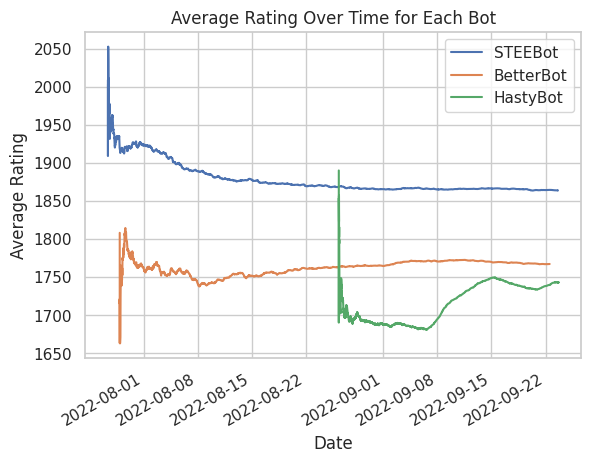

In [ ]:
full_data['created_at'] = pd.to_datetime(full_data['created_at'])

bots_sorted = full_data.sort_values(by='created_at')

nicknames = bots_sorted['bot_name'].unique()

cumulative_averages = pd.DataFrame()

for nickname in nicknames:
    player_data = bots_sorted[bots_sorted['bot_name'] == nickname].copy()
    player_data['cumulative_average'] = player_data['rating'].expanding().mean()
    cumulative_averages = pd.concat([cumulative_averages, player_data])

for nickname in nicknames:
    subset = cumulative_averages[cumulative_averages['bot_name'] == nickname]
    plt.plot(subset['created_at'], subset['cumulative_average'], label=nickname)

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Average Rating Over Time for Each Bot')
plt.legend()
plt.show()

In [ ]:
full_df.to_csv('/content/kaggle/cody_data.csv', index=False)

Now that we have developed a much more detailed dataset to describe players performance for individual games, we want to look at game history. The reasoning behind this is that we are interested in predicting the players rating coming into the game, so it makes logical sense that if we look back in time and see how they were doing previously, our prediction should improve. To do this we will use SQL to develop 3 windows for calculating rolling averages for every column in our data set except for game_id and nickname. The 3 rolling averages we will look at are:
- Previous 3 games rolling average
- Previous 10 games rolling average
- Rolling average for all the games prior to that game for that individual in the data set.

In [ ]:
conn = sqlite3.connect(':memory:')

In [ ]:
full_df.to_sql('games', conn, if_exists='replace', index=False)

72773

In [ ]:
query = """
SELECT *,
AVG(`score`) OVER w1 AS `avg_last_3_score`,
AVG(`rating`) OVER w1 AS `avg_last_3_rating`,
AVG(`first`) OVER w1 AS `avg_last_3_first`,
AVG(`winner`) OVER w1 AS `avg_last_3_winner`,
AVG(`initial_time_seconds`) OVER w1 AS `avg_last_3_initial_time_seconds`,
AVG(`increment_seconds`) OVER w1 AS `avg_last_3_increment_seconds`,
AVG(`max_overtime_minutes`) OVER w1 AS `avg_last_3_max_overtime_minutes`,
AVG(`game_duration_seconds`) OVER w1 AS `avg_last_3_game_duration_seconds`,
AVG(`bot_score`) OVER w1 AS `avg_last_3_bot_score`,
AVG(`bot_rating`) OVER w1 AS `avg_last_3_bot_rating`,
AVG(`points_points_mean`) OVER w1 AS `avg_last_3_points_points_mean`,
AVG(`points_points_max`) OVER w1 AS `avg_last_3_points_points_max`,
AVG(`points_points_var`) OVER w1 AS `avg_last_3_points_points_var`,
AVG(`points_points_min`) OVER w1 AS `avg_last_3_points_points_min`,
AVG(`turn_number_count`) OVER w1 AS `avg_last_3_turn_number_count`,
AVG(`score_max`) OVER w1 AS `avg_last_3_score_max`,
AVG(`turn_type_Challenge_turn_type_Challenge_sum`) OVER w1 AS `avg_last_3_turn_type_Challenge_turn_type_Challenge_sum`,
AVG(`turn_type_Challenge_turn_type_Challenge_mean`) OVER w1 AS `avg_last_3_turn_type_Challenge_turn_type_Challenge_mean`,
AVG(`turn_type_End_turn_type_End_sum`) OVER w1 AS `avg_last_3_turn_type_End_turn_type_End_sum`,
AVG(`turn_type_End_turn_type_End_mean`) OVER w1 AS `avg_last_3_turn_type_End_turn_type_End_mean`,
AVG(`turn_type_Exchange_turn_type_Exchange_sum`) OVER w1 AS `avg_last_3_turn_type_Exchange_turn_type_Exchange_sum`,
AVG(`turn_type_Exchange_turn_type_Exchange_mean`) OVER w1 AS `avg_last_3_turn_type_Exchange_turn_type_Exchange_mean`,
AVG(`turn_type_Pass_turn_type_Pass_sum`) OVER w1 AS `avg_last_3_turn_type_Pass_turn_type_Pass_sum`,
AVG(`turn_type_Pass_turn_type_Pass_mean`) OVER w1 AS `avg_last_3_turn_type_Pass_turn_type_Pass_mean`,
AVG(`turn_type_Play_turn_type_Play_sum`) OVER w1 AS `avg_last_3_turn_type_Play_turn_type_Play_sum`,
AVG(`turn_type_Play_turn_type_Play_mean`) OVER w1 AS `avg_last_3_turn_type_Play_turn_type_Play_mean`,
AVG(`turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum`) OVER w1 AS `avg_last_3_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum`,
AVG(`turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean`) OVER w1 AS `avg_last_3_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean`,
AVG(`turn_type_Timeout_turn_type_Timeout_sum`) OVER w1 AS `avg_last_3_turn_type_Timeout_turn_type_Timeout_sum`,
AVG(`turn_type_Timeout_turn_type_Timeout_mean`) OVER w1 AS `avg_last_3_turn_type_Timeout_turn_type_Timeout_mean`,
AVG(`tiles_placed_tiles_placed_mean`) OVER w1 AS `avg_last_3_tiles_placed_tiles_placed_mean`,
AVG(`tiles_placed_tiles_placed_var`) OVER w1 AS `avg_last_3_tiles_placed_tiles_placed_var`,
AVG(`tiles_placed_tiles_placed_max`) OVER w1 AS `avg_last_3_tiles_placed_tiles_placed_max`,
AVG(`tiles_placed_tiles_placed_min`) OVER w1 AS `avg_last_3_tiles_placed_tiles_placed_min`,
AVG(`difficult_letters_difficult_letters_sum`) OVER w1 AS `avg_last_3_difficult_letters_difficult_letters_sum`,
AVG(`difficult_letters_difficult_letters_mean`) OVER w1 AS `avg_last_3_difficult_letters_difficult_letters_mean`,
AVG(`points_per_tile_placed_points_per_tile_placed_mean`) OVER w1 AS `avg_last_3_points_per_tile_placed_points_per_tile_placed_mean`,
AVG(`points_per_tile_placed_points_per_tile_placed_max`) OVER w1 AS `avg_last_3_points_per_tile_placed_points_per_tile_placed_max`,
AVG(`points_per_tile_placed_points_per_tile_placed_min`) OVER w1 AS `avg_last_3_points_per_tile_placed_points_per_tile_placed_min`,
AVG(`points_per_tile_placed_points_per_tile_placed_var`) OVER w1 AS `avg_last_3_points_per_tile_placed_points_per_tile_placed_var`,
AVG(`0_10_percentile_0_10_percentile_mean`) OVER w1 AS `avg_last_3_0_10_percentile_0_10_percentile_mean`,
AVG(`0_10_percentile_0_10_percentile_sum`) OVER w1 AS `avg_last_3_0_10_percentile_0_10_percentile_sum`,
AVG(`10_20_percentile_10_20_percentile_mean`) OVER w1 AS `avg_last_3_10_20_percentile_10_20_percentile_mean`,
AVG(`10_20_percentile_10_20_percentile_sum`) OVER w1 AS `avg_last_3_10_20_percentile_10_20_percentile_sum`,
AVG(`20_30_percentile_20_30_percentile_mean`) OVER w1 AS `avg_last_3_20_30_percentile_20_30_percentile_mean`,
AVG(`20_30_percentile_20_30_percentile_sum`) OVER w1 AS `avg_last_3_20_30_percentile_20_30_percentile_sum`,
AVG(`30_40_percentile_30_40_percentile_mean`) OVER w1 AS `avg_last_3_30_40_percentile_30_40_percentile_mean`,
AVG(`30_40_percentile_30_40_percentile_sum`) OVER w1 AS `avg_last_3_30_40_percentile_30_40_percentile_sum`,
AVG(`40_50_percentile_40_50_percentile_mean`) OVER w1 AS `avg_last_3_40_50_percentile_40_50_percentile_mean`,
AVG(`40_50_percentile_40_50_percentile_sum`) OVER w1 AS `avg_last_3_40_50_percentile_40_50_percentile_sum`,
AVG(`50_60_percentile_50_60_percentile_mean`) OVER w1 AS `avg_last_3_50_60_percentile_50_60_percentile_mean`,
AVG(`50_60_percentile_50_60_percentile_sum`) OVER w1 AS `avg_last_3_50_60_percentile_50_60_percentile_sum`,
AVG(`60_70_percentile_60_70_percentile_mean`) OVER w1 AS `avg_last_3_60_70_percentile_60_70_percentile_mean`,
AVG(`60_70_percentile_60_70_percentile_sum`) OVER w1 AS `avg_last_3_60_70_percentile_60_70_percentile_sum`,
AVG(`70_80_percentile_70_80_percentile_mean`) OVER w1 AS `avg_last_3_70_80_percentile_70_80_percentile_mean`,
AVG(`70_80_percentile_70_80_percentile_sum`) OVER w1 AS `avg_last_3_70_80_percentile_70_80_percentile_sum`,
AVG(`80_90_percentile_80_90_percentile_mean`) OVER w1 AS `avg_last_3_80_90_percentile_80_90_percentile_mean`,
AVG(`80_90_percentile_80_90_percentile_sum`) OVER w1 AS `avg_last_3_80_90_percentile_80_90_percentile_sum`,
AVG(`90_100_percentile_90_100_percentile_mean`) OVER w1 AS `avg_last_3_90_100_percentile_90_100_percentile_mean`,
AVG(`90_100_percentile_90_100_percentile_sum`) OVER w1 AS `avg_last_3_90_100_percentile_90_100_percentile_sum`,
AVG(`horizontal_placement_sum`) OVER w1 AS `avg_last_3_horizontal_placement_sum`,
AVG(`bot_points_points_mean`) OVER w1 AS `avg_last_3_bot_points_points_mean`,
AVG(`bot_points_points_max`) OVER w1 AS `avg_last_3_bot_points_points_max`,
AVG(`bot_points_points_var`) OVER w1 AS `avg_last_3_bot_points_points_var`,
AVG(`bot_points_points_min`) OVER w1 AS `avg_last_3_bot_points_points_min`,
AVG(`bot_turn_number_count`) OVER w1 AS `avg_last_3_bot_turn_number_count`,
AVG(`bot_score_max`) OVER w1 AS `avg_last_3_bot_score_max`,
AVG(`bot_turn_type_Challenge_turn_type_Challenge_sum`) OVER w1 AS `avg_last_3_bot_turn_type_Challenge_turn_type_Challenge_sum`,
AVG(`bot_turn_type_Challenge_turn_type_Challenge_mean`) OVER w1 AS `avg_last_3_bot_turn_type_Challenge_turn_type_Challenge_mean`,
AVG(`bot_turn_type_End_turn_type_End_sum`) OVER w1 AS `avg_last_3_bot_turn_type_End_turn_type_End_sum`,
AVG(`bot_turn_type_End_turn_type_End_mean`) OVER w1 AS `avg_last_3_bot_turn_type_End_turn_type_End_mean`,
AVG(`bot_turn_type_Exchange_turn_type_Exchange_sum`) OVER w1 AS `avg_last_3_bot_turn_type_Exchange_turn_type_Exchange_sum`,
AVG(`bot_turn_type_Exchange_turn_type_Exchange_mean`) OVER w1 AS `avg_last_3_bot_turn_type_Exchange_turn_type_Exchange_mean`,
AVG(`bot_turn_type_Pass_turn_type_Pass_sum`) OVER w1 AS `avg_last_3_bot_turn_type_Pass_turn_type_Pass_sum`,
AVG(`bot_turn_type_Pass_turn_type_Pass_mean`) OVER w1 AS `avg_last_3_bot_turn_type_Pass_turn_type_Pass_mean`,
AVG(`bot_turn_type_Play_turn_type_Play_sum`) OVER w1 AS `avg_last_3_bot_turn_type_Play_turn_type_Play_sum`,
AVG(`bot_turn_type_Play_turn_type_Play_mean`) OVER w1 AS `avg_last_3_bot_turn_type_Play_turn_type_Play_mean`,
AVG(`bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum`) OVER w1 AS `avg_last_3_bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum`,
AVG(`bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean`) OVER w1 AS `avg_last_3_bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean`,
AVG(`bot_turn_type_Timeout_turn_type_Timeout_sum`) OVER w1 AS `avg_last_3_bot_turn_type_Timeout_turn_type_Timeout_sum`,
AVG(`bot_turn_type_Timeout_turn_type_Timeout_mean`) OVER w1 AS `avg_last_3_bot_turn_type_Timeout_turn_type_Timeout_mean`,
AVG(`bot_tiles_placed_tiles_placed_mean`) OVER w1 AS `avg_last_3_bot_tiles_placed_tiles_placed_mean`,
AVG(`bot_tiles_placed_tiles_placed_var`) OVER w1 AS `avg_last_3_bot_tiles_placed_tiles_placed_var`,
AVG(`bot_tiles_placed_tiles_placed_max`) OVER w1 AS `avg_last_3_bot_tiles_placed_tiles_placed_max`,
AVG(`bot_tiles_placed_tiles_placed_min`) OVER w1 AS `avg_last_3_bot_tiles_placed_tiles_placed_min`,
AVG(`bot_difficult_letters_difficult_letters_sum`) OVER w1 AS `avg_last_3_bot_difficult_letters_difficult_letters_sum`,
AVG(`bot_difficult_letters_difficult_letters_mean`) OVER w1 AS `avg_last_3_bot_difficult_letters_difficult_letters_mean`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_mean`) OVER w1 AS `avg_last_3_bot_points_per_tile_placed_points_per_tile_placed_mean`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_max`) OVER w1 AS `avg_last_3_bot_points_per_tile_placed_points_per_tile_placed_max`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_min`) OVER w1 AS `avg_last_3_bot_points_per_tile_placed_points_per_tile_placed_min`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_var`) OVER w1 AS `avg_last_3_bot_points_per_tile_placed_points_per_tile_placed_var`,
AVG(`bot_0_10_percentile_0_10_percentile_mean`) OVER w1 AS `avg_last_3_bot_0_10_percentile_0_10_percentile_mean`,
AVG(`bot_0_10_percentile_0_10_percentile_sum`) OVER w1 AS `avg_last_3_bot_0_10_percentile_0_10_percentile_sum`,
AVG(`bot_10_20_percentile_10_20_percentile_mean`) OVER w1 AS `avg_last_3_bot_10_20_percentile_10_20_percentile_mean`,
AVG(`bot_10_20_percentile_10_20_percentile_sum`) OVER w1 AS `avg_last_3_bot_10_20_percentile_10_20_percentile_sum`,
AVG(`bot_20_30_percentile_20_30_percentile_mean`) OVER w1 AS `avg_last_3_bot_20_30_percentile_20_30_percentile_mean`,
AVG(`bot_20_30_percentile_20_30_percentile_sum`) OVER w1 AS `avg_last_3_bot_20_30_percentile_20_30_percentile_sum`,
AVG(`bot_30_40_percentile_30_40_percentile_mean`) OVER w1 AS `avg_last_3_bot_30_40_percentile_30_40_percentile_mean`,
AVG(`bot_30_40_percentile_30_40_percentile_sum`) OVER w1 AS `avg_last_3_bot_30_40_percentile_30_40_percentile_sum`,
AVG(`bot_40_50_percentile_40_50_percentile_mean`) OVER w1 AS `avg_last_3_bot_40_50_percentile_40_50_percentile_mean`,
AVG(`bot_40_50_percentile_40_50_percentile_sum`) OVER w1 AS `avg_last_3_bot_40_50_percentile_40_50_percentile_sum`,
AVG(`bot_50_60_percentile_50_60_percentile_mean`) OVER w1 AS `avg_last_3_bot_50_60_percentile_50_60_percentile_mean`,
AVG(`bot_50_60_percentile_50_60_percentile_sum`) OVER w1 AS `avg_last_3_bot_50_60_percentile_50_60_percentile_sum`,
AVG(`bot_60_70_percentile_60_70_percentile_mean`) OVER w1 AS `avg_last_3_bot_60_70_percentile_60_70_percentile_mean`,
AVG(`bot_60_70_percentile_60_70_percentile_sum`) OVER w1 AS `avg_last_3_bot_60_70_percentile_60_70_percentile_sum`,
AVG(`bot_70_80_percentile_70_80_percentile_mean`) OVER w1 AS `avg_last_3_bot_70_80_percentile_70_80_percentile_mean`,
AVG(`bot_70_80_percentile_70_80_percentile_sum`) OVER w1 AS `avg_last_3_bot_70_80_percentile_70_80_percentile_sum`,
AVG(`bot_80_90_percentile_80_90_percentile_mean`) OVER w1 AS `avg_last_3_bot_80_90_percentile_80_90_percentile_mean`,
AVG(`bot_80_90_percentile_80_90_percentile_sum`) OVER w1 AS `avg_last_3_bot_80_90_percentile_80_90_percentile_sum`,
AVG(`bot_90_100_percentile_90_100_percentile_mean`) OVER w1 AS `avg_last_3_bot_90_100_percentile_90_100_percentile_mean`,
AVG(`bot_90_100_percentile_90_100_percentile_sum`) OVER w1 AS `avg_last_3_bot_90_100_percentile_90_100_percentile_sum`,
AVG(`bot_horizontal_placement_sum`) OVER w1 AS `avg_last_3_bot_horizontal_placement_sum`,
AVG(`time_control_name_blitz`) OVER w1 AS `avg_last_3_time_control_name_blitz`,
AVG(`time_control_name_rapid`) OVER w1 AS `avg_last_3_time_control_name_rapid`,
AVG(`time_control_name_regular`) OVER w1 AS `avg_last_3_time_control_name_regular`,
AVG(`time_control_name_ultrablitz`) OVER w1 AS `avg_last_3_time_control_name_ultrablitz`,
AVG(`game_end_reason_CONSECUTIVE_ZEROES`) OVER w1 AS `avg_last_3_game_end_reason_CONSECUTIVE_ZEROES`,
AVG(`game_end_reason_RESIGNED`) OVER w1 AS `avg_last_3_game_end_reason_RESIGNED`,
AVG(`game_end_reason_STANDARD`) OVER w1 AS `avg_last_3_game_end_reason_STANDARD`,
AVG(`game_end_reason_TIME`) OVER w1 AS `avg_last_3_game_end_reason_TIME`,
AVG(`lexicon_CSW21`) OVER w1 AS `avg_last_3_lexicon_CSW21`,
AVG(`lexicon_ECWL`) OVER w1 AS `avg_last_3_lexicon_ECWL`,
AVG(`lexicon_NSWL20`) OVER w1 AS `avg_last_3_lexicon_NSWL20`,
AVG(`lexicon_NWL20`) OVER w1 AS `avg_last_3_lexicon_NWL20`,
AVG(`rating_mode_CASUAL`) OVER w1 AS `avg_last_3_rating_mode_CASUAL`,
AVG(`rating_mode_RATED`) OVER w1 AS `avg_last_3_rating_mode_RATED`,
AVG(`bot_name_BetterBot`) OVER w1 AS `avg_last_3_bot_name_BetterBot`,
AVG(`bot_name_HastyBot`) OVER w1 AS `avg_last_3_bot_name_HastyBot`,
AVG(`bot_name_STEEBot`) OVER w1 AS `avg_last_3_bot_name_STEEBot`,
AVG(`year`) OVER w1 AS `avg_last_3_year`,
AVG(`month`) OVER w1 AS `avg_last_3_month`,
AVG(`day`) OVER w1 AS `avg_last_3_day`,
AVG(`hour`) OVER w1 AS `avg_last_3_hour`,
AVG(`minute`) OVER w1 AS `avg_last_3_minute`,
AVG(`seconds`) OVER w1 AS `avg_last_3_seconds`,
AVG(`score`) OVER w2 AS `avg_score_to_this_point`,
AVG(`rating`) OVER w2 AS `avg_rating_to_this_point`,
AVG(`first`) OVER w2 AS `avg_first_to_this_point`,
AVG(`winner`) OVER w2 AS `avg_winner_to_this_point`,
AVG(`initial_time_seconds`) OVER w2 AS `avg_initial_time_seconds_to_this_point`,
AVG(`increment_seconds`) OVER w2 AS `avg_increment_seconds_to_this_point`,
AVG(`max_overtime_minutes`) OVER w2 AS `avg_max_overtime_minutes_to_this_point`,
AVG(`game_duration_seconds`) OVER w2 AS `avg_game_duration_seconds_to_this_point`,
AVG(`bot_score`) OVER w2 AS `avg_bot_score_to_this_point`,
AVG(`bot_rating`) OVER w2 AS `avg_bot_rating_to_this_point`,
AVG(`points_points_mean`) OVER w2 AS `avg_points_points_mean_to_this_point`,
AVG(`points_points_max`) OVER w2 AS `avg_points_points_max_to_this_point`,
AVG(`points_points_var`) OVER w2 AS `avg_points_points_var_to_this_point`,
AVG(`points_points_min`) OVER w2 AS `avg_points_points_min_to_this_point`,
AVG(`turn_number_count`) OVER w2 AS `avg_turn_number_count_to_this_point`,
AVG(`score_max`) OVER w2 AS `avg_score_max_to_this_point`,
AVG(`turn_type_Challenge_turn_type_Challenge_sum`) OVER w2 AS `avg_turn_type_Challenge_turn_type_Challenge_sum_to_this_point`,
AVG(`turn_type_Challenge_turn_type_Challenge_mean`) OVER w2 AS `avg_turn_type_Challenge_turn_type_Challenge_mean_to_this_point`,
AVG(`turn_type_End_turn_type_End_sum`) OVER w2 AS `avg_turn_type_End_turn_type_End_sum_to_this_point`,
AVG(`turn_type_End_turn_type_End_mean`) OVER w2 AS `avg_turn_type_End_turn_type_End_mean_to_this_point`,
AVG(`turn_type_Exchange_turn_type_Exchange_sum`) OVER w2 AS `avg_turn_type_Exchange_turn_type_Exchange_sum_to_this_point`,
AVG(`turn_type_Exchange_turn_type_Exchange_mean`) OVER w2 AS `avg_turn_type_Exchange_turn_type_Exchange_mean_to_this_point`,
AVG(`turn_type_Pass_turn_type_Pass_sum`) OVER w2 AS `avg_turn_type_Pass_turn_type_Pass_sum_to_this_point`,
AVG(`turn_type_Pass_turn_type_Pass_mean`) OVER w2 AS `avg_turn_type_Pass_turn_type_Pass_mean_to_this_point`,
AVG(`turn_type_Play_turn_type_Play_sum`) OVER w2 AS `avg_turn_type_Play_turn_type_Play_sum_to_this_point`,
AVG(`turn_type_Play_turn_type_Play_mean`) OVER w2 AS `avg_turn_type_Play_turn_type_Play_mean_to_this_point`,
AVG(`turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum`) OVER w2 AS `avg_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum_to_this_point`,
AVG(`turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean`) OVER w2 AS `avg_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean_to_this_point`,
AVG(`turn_type_Timeout_turn_type_Timeout_sum`) OVER w2 AS `avg_turn_type_Timeout_turn_type_Timeout_sum_to_this_point`,
AVG(`turn_type_Timeout_turn_type_Timeout_mean`) OVER w2 AS `avg_turn_type_Timeout_turn_type_Timeout_mean_to_this_point`,
AVG(`tiles_placed_tiles_placed_mean`) OVER w2 AS `avg_tiles_placed_tiles_placed_mean_to_this_point`,
AVG(`tiles_placed_tiles_placed_var`) OVER w2 AS `avg_tiles_placed_tiles_placed_var_to_this_point`,
AVG(`tiles_placed_tiles_placed_max`) OVER w2 AS `avg_tiles_placed_tiles_placed_max_to_this_point`,
AVG(`tiles_placed_tiles_placed_min`) OVER w2 AS `avg_tiles_placed_tiles_placed_min_to_this_point`,
AVG(`difficult_letters_difficult_letters_sum`) OVER w2 AS `avg_difficult_letters_difficult_letters_sum_to_this_point`,
AVG(`difficult_letters_difficult_letters_mean`) OVER w2 AS `avg_difficult_letters_difficult_letters_mean_to_this_point`,
AVG(`points_per_tile_placed_points_per_tile_placed_mean`) OVER w2 AS `avg_points_per_tile_placed_points_per_tile_placed_mean_to_this_point`,
AVG(`points_per_tile_placed_points_per_tile_placed_max`) OVER w2 AS `avg_points_per_tile_placed_points_per_tile_placed_max_to_this_point`,
AVG(`points_per_tile_placed_points_per_tile_placed_min`) OVER w2 AS `avg_points_per_tile_placed_points_per_tile_placed_min_to_this_point`,
AVG(`points_per_tile_placed_points_per_tile_placed_var`) OVER w2 AS `avg_points_per_tile_placed_points_per_tile_placed_var_to_this_point`,
AVG(`0_10_percentile_0_10_percentile_mean`) OVER w2 AS `avg_0_10_percentile_0_10_percentile_mean_to_this_point`,
AVG(`0_10_percentile_0_10_percentile_sum`) OVER w2 AS `avg_0_10_percentile_0_10_percentile_sum_to_this_point`,
AVG(`10_20_percentile_10_20_percentile_mean`) OVER w2 AS `avg_10_20_percentile_10_20_percentile_mean_to_this_point`,
AVG(`10_20_percentile_10_20_percentile_sum`) OVER w2 AS `avg_10_20_percentile_10_20_percentile_sum_to_this_point`,
AVG(`20_30_percentile_20_30_percentile_mean`) OVER w2 AS `avg_20_30_percentile_20_30_percentile_mean_to_this_point`,
AVG(`20_30_percentile_20_30_percentile_sum`) OVER w2 AS `avg_20_30_percentile_20_30_percentile_sum_to_this_point`,
AVG(`30_40_percentile_30_40_percentile_mean`) OVER w2 AS `avg_30_40_percentile_30_40_percentile_mean_to_this_point`,
AVG(`30_40_percentile_30_40_percentile_sum`) OVER w2 AS `avg_30_40_percentile_30_40_percentile_sum_to_this_point`,
AVG(`40_50_percentile_40_50_percentile_mean`) OVER w2 AS `avg_40_50_percentile_40_50_percentile_mean_to_this_point`,
AVG(`40_50_percentile_40_50_percentile_sum`) OVER w2 AS `avg_40_50_percentile_40_50_percentile_sum_to_this_point`,
AVG(`50_60_percentile_50_60_percentile_mean`) OVER w2 AS `avg_50_60_percentile_50_60_percentile_mean_to_this_point`,
AVG(`50_60_percentile_50_60_percentile_sum`) OVER w2 AS `avg_50_60_percentile_50_60_percentile_sum_to_this_point`,
AVG(`60_70_percentile_60_70_percentile_mean`) OVER w2 AS `avg_60_70_percentile_60_70_percentile_mean_to_this_point`,
AVG(`60_70_percentile_60_70_percentile_sum`) OVER w2 AS `avg_60_70_percentile_60_70_percentile_sum_to_this_point`,
AVG(`70_80_percentile_70_80_percentile_mean`) OVER w2 AS `avg_70_80_percentile_70_80_percentile_mean_to_this_point`,
AVG(`70_80_percentile_70_80_percentile_sum`) OVER w2 AS `avg_70_80_percentile_70_80_percentile_sum_to_this_point`,
AVG(`80_90_percentile_80_90_percentile_mean`) OVER w2 AS `avg_80_90_percentile_80_90_percentile_mean_to_this_point`,
AVG(`80_90_percentile_80_90_percentile_sum`) OVER w2 AS `avg_80_90_percentile_80_90_percentile_sum_to_this_point`,
AVG(`90_100_percentile_90_100_percentile_mean`) OVER w2 AS `avg_90_100_percentile_90_100_percentile_mean_to_this_point`,
AVG(`90_100_percentile_90_100_percentile_sum`) OVER w2 AS `avg_90_100_percentile_90_100_percentile_sum_to_this_point`,
AVG(`horizontal_placement_sum`) OVER w2 AS `avg_horizontal_placement_sum_to_this_point`,
AVG(`bot_points_points_mean`) OVER w2 AS `avg_bot_points_points_mean_to_this_point`,
AVG(`bot_points_points_max`) OVER w2 AS `avg_bot_points_points_max_to_this_point`,
AVG(`bot_points_points_var`) OVER w2 AS `avg_bot_points_points_var_to_this_point`,
AVG(`bot_points_points_min`) OVER w2 AS `avg_bot_points_points_min_to_this_point`,
AVG(`bot_turn_number_count`) OVER w2 AS `avg_bot_turn_number_count_to_this_point`,
AVG(`bot_score_max`) OVER w2 AS `avg_bot_score_max_to_this_point`,
AVG(`bot_turn_type_Challenge_turn_type_Challenge_sum`) OVER w2 AS `avg_bot_turn_type_Challenge_turn_type_Challenge_sum_to_this_point`,
AVG(`bot_turn_type_Challenge_turn_type_Challenge_mean`) OVER w2 AS `avg_bot_turn_type_Challenge_turn_type_Challenge_mean_to_this_point`,
AVG(`bot_turn_type_End_turn_type_End_sum`) OVER w2 AS `avg_bot_turn_type_End_turn_type_End_sum_to_this_point`,
AVG(`bot_turn_type_End_turn_type_End_mean`) OVER w2 AS `avg_bot_turn_type_End_turn_type_End_mean_to_this_point`,
AVG(`bot_turn_type_Exchange_turn_type_Exchange_sum`) OVER w2 AS `avg_bot_turn_type_Exchange_turn_type_Exchange_sum_to_this_point`,
AVG(`bot_turn_type_Exchange_turn_type_Exchange_mean`) OVER w2 AS `avg_bot_turn_type_Exchange_turn_type_Exchange_mean_to_this_point`,
AVG(`bot_turn_type_Pass_turn_type_Pass_sum`) OVER w2 AS `avg_bot_turn_type_Pass_turn_type_Pass_sum_to_this_point`,
AVG(`bot_turn_type_Pass_turn_type_Pass_mean`) OVER w2 AS `avg_bot_turn_type_Pass_turn_type_Pass_mean_to_this_point`,
AVG(`bot_turn_type_Play_turn_type_Play_sum`) OVER w2 AS `avg_bot_turn_type_Play_turn_type_Play_sum_to_this_point`,
AVG(`bot_turn_type_Play_turn_type_Play_mean`) OVER w2 AS `avg_bot_turn_type_Play_turn_type_Play_mean_to_this_point`,
AVG(`bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum`) OVER w2 AS `avg_bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum_to_this_point`,
AVG(`bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean`) OVER w2 AS `avg_bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean_to_this_point`,
AVG(`bot_turn_type_Timeout_turn_type_Timeout_sum`) OVER w2 AS `avg_bot_turn_type_Timeout_turn_type_Timeout_sum_to_this_point`,
AVG(`bot_turn_type_Timeout_turn_type_Timeout_mean`) OVER w2 AS `avg_bot_turn_type_Timeout_turn_type_Timeout_mean_to_this_point`,
AVG(`bot_tiles_placed_tiles_placed_mean`) OVER w2 AS `avg_bot_tiles_placed_tiles_placed_mean_to_this_point`,
AVG(`bot_tiles_placed_tiles_placed_var`) OVER w2 AS `avg_bot_tiles_placed_tiles_placed_var_to_this_point`,
AVG(`bot_tiles_placed_tiles_placed_max`) OVER w2 AS `avg_bot_tiles_placed_tiles_placed_max_to_this_point`,
AVG(`bot_tiles_placed_tiles_placed_min`) OVER w2 AS `avg_bot_tiles_placed_tiles_placed_min_to_this_point`,
AVG(`bot_difficult_letters_difficult_letters_sum`) OVER w2 AS `avg_bot_difficult_letters_difficult_letters_sum_to_this_point`,
AVG(`bot_difficult_letters_difficult_letters_mean`) OVER w2 AS `avg_bot_difficult_letters_difficult_letters_mean_to_this_point`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_mean`) OVER w2 AS `avg_bot_points_per_tile_placed_points_per_tile_placed_mean_to_this_point`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_max`) OVER w2 AS `avg_bot_points_per_tile_placed_points_per_tile_placed_max_to_this_point`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_min`) OVER w2 AS `avg_bot_points_per_tile_placed_points_per_tile_placed_min_to_this_point`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_var`) OVER w2 AS `avg_bot_points_per_tile_placed_points_per_tile_placed_var_to_this_point`,
AVG(`bot_0_10_percentile_0_10_percentile_mean`) OVER w2 AS `avg_bot_0_10_percentile_0_10_percentile_mean_to_this_point`,
AVG(`bot_0_10_percentile_0_10_percentile_sum`) OVER w2 AS `avg_bot_0_10_percentile_0_10_percentile_sum_to_this_point`,
AVG(`bot_10_20_percentile_10_20_percentile_mean`) OVER w2 AS `avg_bot_10_20_percentile_10_20_percentile_mean_to_this_point`,
AVG(`bot_10_20_percentile_10_20_percentile_sum`) OVER w2 AS `avg_bot_10_20_percentile_10_20_percentile_sum_to_this_point`,
AVG(`bot_20_30_percentile_20_30_percentile_mean`) OVER w2 AS `avg_bot_20_30_percentile_20_30_percentile_mean_to_this_point`,
AVG(`bot_20_30_percentile_20_30_percentile_sum`) OVER w2 AS `avg_bot_20_30_percentile_20_30_percentile_sum_to_this_point`,
AVG(`bot_30_40_percentile_30_40_percentile_mean`) OVER w2 AS `avg_bot_30_40_percentile_30_40_percentile_mean_to_this_point`,
AVG(`bot_30_40_percentile_30_40_percentile_sum`) OVER w2 AS `avg_bot_30_40_percentile_30_40_percentile_sum_to_this_point`,
AVG(`bot_40_50_percentile_40_50_percentile_mean`) OVER w2 AS `avg_bot_40_50_percentile_40_50_percentile_mean_to_this_point`,
AVG(`bot_40_50_percentile_40_50_percentile_sum`) OVER w2 AS `avg_bot_40_50_percentile_40_50_percentile_sum_to_this_point`,
AVG(`bot_50_60_percentile_50_60_percentile_mean`) OVER w2 AS `avg_bot_50_60_percentile_50_60_percentile_mean_to_this_point`,
AVG(`bot_50_60_percentile_50_60_percentile_sum`) OVER w2 AS `avg_bot_50_60_percentile_50_60_percentile_sum_to_this_point`,
AVG(`bot_60_70_percentile_60_70_percentile_mean`) OVER w2 AS `avg_bot_60_70_percentile_60_70_percentile_mean_to_this_point`,
AVG(`bot_60_70_percentile_60_70_percentile_sum`) OVER w2 AS `avg_bot_60_70_percentile_60_70_percentile_sum_to_this_point`,
AVG(`bot_70_80_percentile_70_80_percentile_mean`) OVER w2 AS `avg_bot_70_80_percentile_70_80_percentile_mean_to_this_point`,
AVG(`bot_70_80_percentile_70_80_percentile_sum`) OVER w2 AS `avg_bot_70_80_percentile_70_80_percentile_sum_to_this_point`,
AVG(`bot_80_90_percentile_80_90_percentile_mean`) OVER w2 AS `avg_bot_80_90_percentile_80_90_percentile_mean_to_this_point`,
AVG(`bot_80_90_percentile_80_90_percentile_sum`) OVER w2 AS `avg_bot_80_90_percentile_80_90_percentile_sum_to_this_point`,
AVG(`bot_90_100_percentile_90_100_percentile_mean`) OVER w2 AS `avg_bot_90_100_percentile_90_100_percentile_mean_to_this_point`,
AVG(`bot_90_100_percentile_90_100_percentile_sum`) OVER w2 AS `avg_bot_90_100_percentile_90_100_percentile_sum_to_this_point`,
AVG(`bot_horizontal_placement_sum`) OVER w2 AS `avg_bot_horizontal_placement_sum_to_this_point`,
AVG(`time_control_name_blitz`) OVER w2 AS `avg_time_control_name_blitz_to_this_point`,
AVG(`time_control_name_rapid`) OVER w2 AS `avg_time_control_name_rapid_to_this_point`,
AVG(`time_control_name_regular`) OVER w2 AS `avg_time_control_name_regular_to_this_point`,
AVG(`time_control_name_ultrablitz`) OVER w2 AS `avg_time_control_name_ultrablitz_to_this_point`,
AVG(`game_end_reason_CONSECUTIVE_ZEROES`) OVER w2 AS `avg_game_end_reason_CONSECUTIVE_ZEROES_to_this_point`,
AVG(`game_end_reason_RESIGNED`) OVER w2 AS `avg_game_end_reason_RESIGNED_to_this_point`,
AVG(`game_end_reason_STANDARD`) OVER w2 AS `avg_game_end_reason_STANDARD_to_this_point`,
AVG(`game_end_reason_TIME`) OVER w2 AS `avg_game_end_reason_TIME_to_this_point`,
AVG(`lexicon_CSW21`) OVER w2 AS `avg_lexicon_CSW21_to_this_point`,
AVG(`lexicon_ECWL`) OVER w2 AS `avg_lexicon_ECWL_to_this_point`,
AVG(`lexicon_NSWL20`) OVER w2 AS `avg_lexicon_NSWL20_to_this_point`,
AVG(`lexicon_NWL20`) OVER w2 AS `avg_lexicon_NWL20_to_this_point`,
AVG(`rating_mode_CASUAL`) OVER w2 AS `avg_rating_mode_CASUAL_to_this_point`,
AVG(`rating_mode_RATED`) OVER w2 AS `avg_rating_mode_RATED_to_this_point`,
AVG(`bot_name_BetterBot`) OVER w2 AS `avg_bot_name_BetterBot_to_this_point`,
AVG(`bot_name_HastyBot`) OVER w2 AS `avg_bot_name_HastyBot_to_this_point`,
AVG(`bot_name_STEEBot`) OVER w2 AS `avg_bot_name_STEEBot_to_this_point`,
AVG(`year`) OVER w2 AS `avg_year_to_this_point`,
AVG(`month`) OVER w2 AS `avg_month_to_this_point`,
AVG(`day`) OVER w2 AS `avg_day_to_this_point`,
AVG(`hour`) OVER w2 AS `avg_hour_to_this_point`,
AVG(`minute`) OVER w2 AS `avg_minute_to_this_point`,
AVG(`seconds`) OVER w2 AS `avg_seconds_to_this_point`,
AVG(`score`) OVER w3 AS `avg_last_10_score`,
AVG(`rating`) OVER w3 AS `avg_last_10_rating`,
AVG(`first`) OVER w3 AS `avg_last_10_first`,
AVG(`winner`) OVER w3 AS `avg_last_10_winner`,
AVG(`initial_time_seconds`) OVER w3 AS `avg_last_10_initial_time_seconds`,
AVG(`increment_seconds`) OVER w3 AS `avg_last_10_increment_seconds`,
AVG(`max_overtime_minutes`) OVER w3 AS `avg_last_10_max_overtime_minutes`,
AVG(`game_duration_seconds`) OVER w3 AS `avg_last_10_game_duration_seconds`,
AVG(`bot_score`) OVER w3 AS `avg_last_10_bot_score`,
AVG(`bot_rating`) OVER w3 AS `avg_last_10_bot_rating`,
AVG(`points_points_mean`) OVER w3 AS `avg_last_10_points_points_mean`,
AVG(`points_points_max`) OVER w3 AS `avg_last_10_points_points_max`,
AVG(`points_points_var`) OVER w3 AS `avg_last_10_points_points_var`,
AVG(`points_points_min`) OVER w3 AS `avg_last_10_points_points_min`,
AVG(`turn_number_count`) OVER w3 AS `avg_last_10_turn_number_count`,
AVG(`score_max`) OVER w3 AS `avg_last_10_score_max`,
AVG(`turn_type_Challenge_turn_type_Challenge_sum`) OVER w3 AS `avg_last_10_turn_type_Challenge_turn_type_Challenge_sum`,
AVG(`turn_type_Challenge_turn_type_Challenge_mean`) OVER w3 AS `avg_last_10_turn_type_Challenge_turn_type_Challenge_mean`,
AVG(`turn_type_End_turn_type_End_sum`) OVER w3 AS `avg_last_10_turn_type_End_turn_type_End_sum`,
AVG(`turn_type_End_turn_type_End_mean`) OVER w3 AS `avg_last_10_turn_type_End_turn_type_End_mean`,
AVG(`turn_type_Exchange_turn_type_Exchange_sum`) OVER w3 AS `avg_last_10_turn_type_Exchange_turn_type_Exchange_sum`,
AVG(`turn_type_Exchange_turn_type_Exchange_mean`) OVER w3 AS `avg_last_10_turn_type_Exchange_turn_type_Exchange_mean`,
AVG(`turn_type_Pass_turn_type_Pass_sum`) OVER w3 AS `avg_last_10_turn_type_Pass_turn_type_Pass_sum`,
AVG(`turn_type_Pass_turn_type_Pass_mean`) OVER w3 AS `avg_last_10_turn_type_Pass_turn_type_Pass_mean`,
AVG(`turn_type_Play_turn_type_Play_sum`) OVER w3 AS `avg_last_10_turn_type_Play_turn_type_Play_sum`,
AVG(`turn_type_Play_turn_type_Play_mean`) OVER w3 AS `avg_last_10_turn_type_Play_turn_type_Play_mean`,
AVG(`turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum`) OVER w3 AS `avg_last_10_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum`,
AVG(`turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean`) OVER w3 AS `avg_last_10_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean`,
AVG(`turn_type_Timeout_turn_type_Timeout_sum`) OVER w3 AS `avg_last_10_turn_type_Timeout_turn_type_Timeout_sum`,
AVG(`turn_type_Timeout_turn_type_Timeout_mean`) OVER w3 AS `avg_last_10_turn_type_Timeout_turn_type_Timeout_mean`,
AVG(`tiles_placed_tiles_placed_mean`) OVER w3 AS `avg_last_10_tiles_placed_tiles_placed_mean`,
AVG(`tiles_placed_tiles_placed_var`) OVER w3 AS `avg_last_10_tiles_placed_tiles_placed_var`,
AVG(`tiles_placed_tiles_placed_max`) OVER w3 AS `avg_last_10_tiles_placed_tiles_placed_max`,
AVG(`tiles_placed_tiles_placed_min`) OVER w3 AS `avg_last_10_tiles_placed_tiles_placed_min`,
AVG(`difficult_letters_difficult_letters_sum`) OVER w3 AS `avg_last_10_difficult_letters_difficult_letters_sum`,
AVG(`difficult_letters_difficult_letters_mean`) OVER w3 AS `avg_last_10_difficult_letters_difficult_letters_mean`,
AVG(`points_per_tile_placed_points_per_tile_placed_mean`) OVER w3 AS `avg_last_10_points_per_tile_placed_points_per_tile_placed_mean`,
AVG(`points_per_tile_placed_points_per_tile_placed_max`) OVER w3 AS `avg_last_10_points_per_tile_placed_points_per_tile_placed_max`,
AVG(`points_per_tile_placed_points_per_tile_placed_min`) OVER w3 AS `avg_last_10_points_per_tile_placed_points_per_tile_placed_min`,
AVG(`points_per_tile_placed_points_per_tile_placed_var`) OVER w3 AS `avg_last_10_points_per_tile_placed_points_per_tile_placed_var`,
AVG(`0_10_percentile_0_10_percentile_mean`) OVER w3 AS `avg_last_10_0_10_percentile_0_10_percentile_mean`,
AVG(`0_10_percentile_0_10_percentile_sum`) OVER w3 AS `avg_last_10_0_10_percentile_0_10_percentile_sum`,
AVG(`10_20_percentile_10_20_percentile_mean`) OVER w3 AS `avg_last_10_10_20_percentile_10_20_percentile_mean`,
AVG(`10_20_percentile_10_20_percentile_sum`) OVER w3 AS `avg_last_10_10_20_percentile_10_20_percentile_sum`,
AVG(`20_30_percentile_20_30_percentile_mean`) OVER w3 AS `avg_last_10_20_30_percentile_20_30_percentile_mean`,
AVG(`20_30_percentile_20_30_percentile_sum`) OVER w3 AS `avg_last_10_20_30_percentile_20_30_percentile_sum`,
AVG(`30_40_percentile_30_40_percentile_mean`) OVER w3 AS `avg_last_10_30_40_percentile_30_40_percentile_mean`,
AVG(`30_40_percentile_30_40_percentile_sum`) OVER w3 AS `avg_last_10_30_40_percentile_30_40_percentile_sum`,
AVG(`40_50_percentile_40_50_percentile_mean`) OVER w3 AS `avg_last_10_40_50_percentile_40_50_percentile_mean`,
AVG(`40_50_percentile_40_50_percentile_sum`) OVER w3 AS `avg_last_10_40_50_percentile_40_50_percentile_sum`,
AVG(`50_60_percentile_50_60_percentile_mean`) OVER w3 AS `avg_last_10_50_60_percentile_50_60_percentile_mean`,
AVG(`50_60_percentile_50_60_percentile_sum`) OVER w3 AS `avg_last_10_50_60_percentile_50_60_percentile_sum`,
AVG(`60_70_percentile_60_70_percentile_mean`) OVER w3 AS `avg_last_10_60_70_percentile_60_70_percentile_mean`,
AVG(`60_70_percentile_60_70_percentile_sum`) OVER w3 AS `avg_last_10_60_70_percentile_60_70_percentile_sum`,
AVG(`70_80_percentile_70_80_percentile_mean`) OVER w3 AS `avg_last_10_70_80_percentile_70_80_percentile_mean`,
AVG(`70_80_percentile_70_80_percentile_sum`) OVER w3 AS `avg_last_10_70_80_percentile_70_80_percentile_sum`,
AVG(`80_90_percentile_80_90_percentile_mean`) OVER w3 AS `avg_last_10_80_90_percentile_80_90_percentile_mean`,
AVG(`80_90_percentile_80_90_percentile_sum`) OVER w3 AS `avg_last_10_80_90_percentile_80_90_percentile_sum`,
AVG(`90_100_percentile_90_100_percentile_mean`) OVER w3 AS `avg_last_10_90_100_percentile_90_100_percentile_mean`,
AVG(`90_100_percentile_90_100_percentile_sum`) OVER w3 AS `avg_last_10_90_100_percentile_90_100_percentile_sum`,
AVG(`horizontal_placement_sum`) OVER w3 AS `avg_last_10_horizontal_placement_sum`,
AVG(`bot_points_points_mean`) OVER w3 AS `avg_last_10_bot_points_points_mean`,
AVG(`bot_points_points_max`) OVER w3 AS `avg_last_10_bot_points_points_max`,
AVG(`bot_points_points_var`) OVER w3 AS `avg_last_10_bot_points_points_var`,
AVG(`bot_points_points_min`) OVER w3 AS `avg_last_10_bot_points_points_min`,
AVG(`bot_turn_number_count`) OVER w3 AS `avg_last_10_bot_turn_number_count`,
AVG(`bot_score_max`) OVER w3 AS `avg_last_10_bot_score_max`,
AVG(`bot_turn_type_Challenge_turn_type_Challenge_sum`) OVER w3 AS `avg_last_10_bot_turn_type_Challenge_turn_type_Challenge_sum`,
AVG(`bot_turn_type_Challenge_turn_type_Challenge_mean`) OVER w3 AS `avg_last_10_bot_turn_type_Challenge_turn_type_Challenge_mean`,
AVG(`bot_turn_type_End_turn_type_End_sum`) OVER w3 AS `avg_last_10_bot_turn_type_End_turn_type_End_sum`,
AVG(`bot_turn_type_End_turn_type_End_mean`) OVER w3 AS `avg_last_10_bot_turn_type_End_turn_type_End_mean`,
AVG(`bot_turn_type_Exchange_turn_type_Exchange_sum`) OVER w3 AS `avg_last_10_bot_turn_type_Exchange_turn_type_Exchange_sum`,
AVG(`bot_turn_type_Exchange_turn_type_Exchange_mean`) OVER w3 AS `avg_last_10_bot_turn_type_Exchange_turn_type_Exchange_mean`,
AVG(`bot_turn_type_Pass_turn_type_Pass_sum`) OVER w3 AS `avg_last_10_bot_turn_type_Pass_turn_type_Pass_sum`,
AVG(`bot_turn_type_Pass_turn_type_Pass_mean`) OVER w3 AS `avg_last_10_bot_turn_type_Pass_turn_type_Pass_mean`,
AVG(`bot_turn_type_Play_turn_type_Play_sum`) OVER w3 AS `avg_last_10_bot_turn_type_Play_turn_type_Play_sum`,
AVG(`bot_turn_type_Play_turn_type_Play_mean`) OVER w3 AS `avg_last_10_bot_turn_type_Play_turn_type_Play_mean`,
AVG(`bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum`) OVER w3 AS `avg_last_10_bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum`,
AVG(`bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean`) OVER w3 AS `avg_last_10_bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_mean`,
AVG(`bot_turn_type_Timeout_turn_type_Timeout_sum`) OVER w3 AS `avg_last_10_bot_turn_type_Timeout_turn_type_Timeout_sum`,
AVG(`bot_turn_type_Timeout_turn_type_Timeout_mean`) OVER w3 AS `avg_last_10_bot_turn_type_Timeout_turn_type_Timeout_mean`,
AVG(`bot_tiles_placed_tiles_placed_mean`) OVER w3 AS `avg_last_10_bot_tiles_placed_tiles_placed_mean`,
AVG(`bot_tiles_placed_tiles_placed_var`) OVER w3 AS `avg_last_10_bot_tiles_placed_tiles_placed_var`,
AVG(`bot_tiles_placed_tiles_placed_max`) OVER w3 AS `avg_last_10_bot_tiles_placed_tiles_placed_max`,
AVG(`bot_tiles_placed_tiles_placed_min`) OVER w3 AS `avg_last_10_bot_tiles_placed_tiles_placed_min`,
AVG(`bot_difficult_letters_difficult_letters_sum`) OVER w3 AS `avg_last_10_bot_difficult_letters_difficult_letters_sum`,
AVG(`bot_difficult_letters_difficult_letters_mean`) OVER w3 AS `avg_last_10_bot_difficult_letters_difficult_letters_mean`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_mean`) OVER w3 AS `avg_last_10_bot_points_per_tile_placed_points_per_tile_placed_mean`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_max`) OVER w3 AS `avg_last_10_bot_points_per_tile_placed_points_per_tile_placed_max`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_min`) OVER w3 AS `avg_last_10_bot_points_per_tile_placed_points_per_tile_placed_min`,
AVG(`bot_points_per_tile_placed_points_per_tile_placed_var`) OVER w3 AS `avg_last_10_bot_points_per_tile_placed_points_per_tile_placed_var`,
AVG(`bot_0_10_percentile_0_10_percentile_mean`) OVER w3 AS `avg_last_10_bot_0_10_percentile_0_10_percentile_mean`,
AVG(`bot_0_10_percentile_0_10_percentile_sum`) OVER w3 AS `avg_last_10_bot_0_10_percentile_0_10_percentile_sum`,
AVG(`bot_10_20_percentile_10_20_percentile_mean`) OVER w3 AS `avg_last_10_bot_10_20_percentile_10_20_percentile_mean`,
AVG(`bot_10_20_percentile_10_20_percentile_sum`) OVER w3 AS `avg_last_10_bot_10_20_percentile_10_20_percentile_sum`,
AVG(`bot_20_30_percentile_20_30_percentile_mean`) OVER w3 AS `avg_last_10_bot_20_30_percentile_20_30_percentile_mean`,
AVG(`bot_20_30_percentile_20_30_percentile_sum`) OVER w3 AS `avg_last_10_bot_20_30_percentile_20_30_percentile_sum`,
AVG(`bot_30_40_percentile_30_40_percentile_mean`) OVER w3 AS `avg_last_10_bot_30_40_percentile_30_40_percentile_mean`,
AVG(`bot_30_40_percentile_30_40_percentile_sum`) OVER w3 AS `avg_last_10_bot_30_40_percentile_30_40_percentile_sum`,
AVG(`bot_40_50_percentile_40_50_percentile_mean`) OVER w3 AS `avg_last_10_bot_40_50_percentile_40_50_percentile_mean`,
AVG(`bot_40_50_percentile_40_50_percentile_sum`) OVER w3 AS `avg_last_10_bot_40_50_percentile_40_50_percentile_sum`,
AVG(`bot_50_60_percentile_50_60_percentile_mean`) OVER w3 AS `avg_last_10_bot_50_60_percentile_50_60_percentile_mean`,
AVG(`bot_50_60_percentile_50_60_percentile_sum`) OVER w3 AS `avg_last_10_bot_50_60_percentile_50_60_percentile_sum`,
AVG(`bot_60_70_percentile_60_70_percentile_mean`) OVER w3 AS `avg_last_10_bot_60_70_percentile_60_70_percentile_mean`,
AVG(`bot_60_70_percentile_60_70_percentile_sum`) OVER w3 AS `avg_last_10_bot_60_70_percentile_60_70_percentile_sum`,
AVG(`bot_70_80_percentile_70_80_percentile_mean`) OVER w3 AS `avg_last_10_bot_70_80_percentile_70_80_percentile_mean`,
AVG(`bot_70_80_percentile_70_80_percentile_sum`) OVER w3 AS `avg_last_10_bot_70_80_percentile_70_80_percentile_sum`,
AVG(`bot_80_90_percentile_80_90_percentile_mean`) OVER w3 AS `avg_last_10_bot_80_90_percentile_80_90_percentile_mean`,
AVG(`bot_80_90_percentile_80_90_percentile_sum`) OVER w3 AS `avg_last_10_bot_80_90_percentile_80_90_percentile_sum`,
AVG(`bot_90_100_percentile_90_100_percentile_mean`) OVER w3 AS `avg_last_10_bot_90_100_percentile_90_100_percentile_mean`,
AVG(`bot_90_100_percentile_90_100_percentile_sum`) OVER w3 AS `avg_last_10_bot_90_100_percentile_90_100_percentile_sum`,
AVG(`bot_horizontal_placement_sum`) OVER w3 AS `avg_last_10_bot_horizontal_placement_sum`,
AVG(`time_control_name_blitz`) OVER w3 AS `avg_last_10_time_control_name_blitz`,
AVG(`time_control_name_rapid`) OVER w3 AS `avg_last_10_time_control_name_rapid`,
AVG(`time_control_name_regular`) OVER w3 AS `avg_last_10_time_control_name_regular`,
AVG(`time_control_name_ultrablitz`) OVER w3 AS `avg_last_10_time_control_name_ultrablitz`,
AVG(`game_end_reason_CONSECUTIVE_ZEROES`) OVER w3 AS `avg_last_10_game_end_reason_CONSECUTIVE_ZEROES`,
AVG(`game_end_reason_RESIGNED`) OVER w3 AS `avg_last_10_game_end_reason_RESIGNED`,
AVG(`game_end_reason_STANDARD`) OVER w3 AS `avg_last_10_game_end_reason_STANDARD`,
AVG(`game_end_reason_TIME`) OVER w3 AS `avg_last_10_game_end_reason_TIME`,
AVG(`lexicon_CSW21`) OVER w3 AS `avg_last_10_lexicon_CSW21`,
AVG(`lexicon_ECWL`) OVER w3 AS `avg_last_10_lexicon_ECWL`,
AVG(`lexicon_NSWL20`) OVER w3 AS `avg_last_10_lexicon_NSWL20`,
AVG(`lexicon_NWL20`) OVER w3 AS `avg_last_10_lexicon_NWL20`,
AVG(`rating_mode_CASUAL`) OVER w3 AS `avg_last_10_rating_mode_CASUAL`,
AVG(`rating_mode_RATED`) OVER w3 AS `avg_last_10_rating_mode_RATED`,
AVG(`bot_name_BetterBot`) OVER w3 AS `avg_last_10_bot_name_BetterBot`,
AVG(`bot_name_HastyBot`) OVER w3 AS `avg_last_10_bot_name_HastyBot`,
AVG(`bot_name_STEEBot`) OVER w3 AS `avg_last_10_bot_name_STEEBot`,
AVG(`year`) OVER w3 AS `avg_last_10_year`,
AVG(`month`) OVER w3 AS `avg_last_10_month`,
AVG(`day`) OVER w3 AS `avg_last_10_day`,
AVG(`hour`) OVER w3 AS `avg_last_10_hour`,
AVG(`minute`) OVER w3 AS `avg_last_10_minute`,
AVG(`seconds`) OVER w3 AS `avg_last_10_seconds`
FROM
    games
WINDOW w1 AS (PARTITION BY `nickname` ORDER BY `year`, `month`, `day`, `hour`, `minute`, `seconds` ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING),
	w2 AS (PARTITION BY `nickname` ORDER BY `year`, `month`, `day`, `hour`, `minute`, `seconds` ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING),
  w3 AS (PARTITION BY `nickname` ORDER BY `year`, `month`, `day`, `hour`, `minute`, `seconds` ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING)
ORDER BY
    `nickname`, `year`, `month`, `day`, `hour`, `minute`, `seconds`;
"""

Then, we simply take the results of that SQL query and make it our new data set for creating our models.

In [ ]:
result_df = pd.read_sql_query(query, conn)

In [ ]:
conn.close()

In [ ]:
df_cody = result_df

In [ ]:
result_df

,game_id,nickname,score,rating,first,winner,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,...,avg_last_10_rating_mode_RATED,avg_last_10_bot_name_BetterBot,avg_last_10_bot_name_HastyBot,avg_last_10_bot_name_STEEBot,avg_last_10_year,avg_last_10_month,avg_last_10_day,avg_last_10_hour,avg_last_10_minute,avg_last_10_seconds
0,43828,0188889876,15,1979.0,0,0,15,0,1,61.405180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5765,0927399533,141,1447.0,1,0,1200,0,1,1268.252752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40264,0927399533,212,1408.0,0,0,1200,0,1,1262.786704,...,1.0,1.000000,0.000000,0.0,2022.0,8.000000,9.000000,14.000000,25.000000,28.000000
3,44376,0927399533,227,1372.0,1,0,1200,0,1,1209.746654,...,1.0,1.000000,0.000000,0.0,2022.0,8.000000,9.000000,14.500000,25.500000,41.000000
4,32633,0927399533,391,1367.0,0,1,1200,0,1,1231.166683,...,1.0,1.000000,0.000000,0.0,2022.0,8.000000,9.333333,15.000000,26.333333,41.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72768,7264,zuzu,327,1855.0,1,0,1200,0,1,683.258274,...,1.0,0.666667,0.333333,0.0,2022.0,8.333333,22.333333,7.000000,30.666667,32.833333
72769,66022,zyzzyva,357,1641.0,1,0,1380,0,1,626.274697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72770,2581,zyzzyva,438,1637.0,0,1,1380,0,1,775.765387,...,1.0,0.000000,0.000000,1.0,2022.0,7.000000,28.000000,18.000000,47.000000,59.000000
72771,54204,zyzzyva,412,1626.0,0,1,1200,0,1,624.940244,...,1.0,0.000000,0.000000,1.0,2022.0,7.000000,28.000000,18.000000,52.500000,47.500000


In [ ]:
result_df['game_id'].max()

72773

The games where the rating is null is our training set, as this is what we are trying to predict.

In [ ]:
result_df[result_df['rating'].isna()]

,game_id,nickname,score,rating,first,winner,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,...,avg_last_10_rating_mode_RATED,avg_last_10_bot_name_BetterBot,avg_last_10_bot_name_HastyBot,avg_last_10_bot_name_STEEBot,avg_last_10_year,avg_last_10_month,avg_last_10_day,avg_last_10_hour,avg_last_10_minute,avg_last_10_seconds
22,51857,10IQPlays,331,NaN,0,0,1200,0,1,632.083319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,31730,2204677_WANG.J,118,NaN,0,0,1200,0,1,256.453327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,50150,2204677_WANG.J,135,NaN,0,0,1200,0,1,245.164982,...,1.0,0.0,1.0,0.0,2022.0,8.0,26.0,9.0,27.0,43.0
60,18710,220677_YOYO,274,NaN,1,0,780,0,1,798.728617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,46342,220677_YOYO,332,NaN,0,0,780,0,1,841.983634,...,0.0,0.0,0.0,1.0,2022.0,8.0,6.0,3.0,59.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72722,5506,zk,366,NaN,0,0,900,0,1,471.077622,...,1.0,0.0,1.0,0.0,2022.0,9.0,21.0,8.3,40.0,34.1
72723,26454,zk,348,NaN,1,0,900,0,1,421.667981,...,1.0,0.0,1.0,0.0,2022.0,9.0,21.2,8.3,35.1,31.5
72724,14102,zk,341,NaN,0,0,900,0,1,295.437074,...,1.0,0.0,1.0,0.0,2022.0,9.0,21.4,8.7,34.6,31.3
72725,69347,zk,460,NaN,1,0,900,0,1,248.825438,...,1.0,0.0,1.0,0.0,2022.0,9.0,21.6,9.1,33.9,27.7


In [ ]:
result_df.to_csv('/content/kaggle/cody_datas4.csv', index=False)

##3.02: Loading and preparing primary model train/test data

In [ ]:
### PRIMARY DATA (CODY'S FEATURES ONLY FOR NOW UNTIL WE FIX BUGS) ###

In [ ]:
cody_datas4 = pd.read_csv("/content/kaggle/cody_datas4.csv")
#cody_datas4
cody_datas4.sort_values('game_id', inplace=True)

We will drop the nickname column as this doesn't hold any predictive power for us:

In [ ]:
cody_datas4 = cody_datas4.drop('nickname',axis=1).reset_index(drop=True)
#cody_datas4

Again, as we mentioned previously, the rows with a null rating is the data that we will use as our training set. Therefore, we split the data now into our training set (rows with null values in rating) and our training set (rows without null values in rating):

In [ ]:
# Filtering out rows where 'rating' is missing
test_data_c = cody_datas4[cody_datas4['rating'].isna()]

In [ ]:
# Dropping rows with missing 'rating' from the main DataFrame
train_data_c = cody_datas4.dropna(subset = ['rating'])

We want to store game id as a variable to eventually attach back to our predictions for submission to Kaggle, however, we want to remove it from the test_data because we do not want to feed it into our predictive modeling:

In [ ]:
# Extracting 'game_id' and then dropping several columns from 'test_data'
game_id = test_data_c['game_id']
test_data_c.drop(['game_id', 'rating'], axis = 1, inplace = True)

<ipython-input-103-1357c760bf26>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_c.drop(['game_id', 'rating'], axis = 1, inplace = True)


As a result of taking the rolling averages of the previous games played by the user, all the rows in our data set where it was the first game played by user will now have null values for the rolling average features. Rather than dropping these rows and losing a lot of data, we decide to do KNN Imputation to fill the null values. We choose k = 5 to do so:

In [ ]:
imputer = KNNImputer(n_neighbors=5)
test_data_i = imputer.fit_transform(test_data_c)

In [ ]:
test_data_c = pd.DataFrame(test_data_i, columns=imputer.get_feature_names_out())

In [ ]:
test_data_c.dropna(inplace = True)

In [ ]:
imputer2 = KNNImputer(n_neighbors=5)
train_data_i = imputer2.fit_transform(train_data_c)

In [ ]:
train_data_c = pd.DataFrame(train_data_i, columns=imputer2.get_feature_names_out())

In [ ]:
train_data_c.dropna(inplace = True)

In [ ]:
test_data_c

,score,first,winner,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,bot_score,bot_rating,points_points_mean,...,avg_last_10_rating_mode_RATED,avg_last_10_bot_name_BetterBot,avg_last_10_bot_name_HastyBot,avg_last_10_bot_name_STEEBot,avg_last_10_year,avg_last_10_month,avg_last_10_day,avg_last_10_hour,avg_last_10_minute,avg_last_10_seconds
0,488.0,1.0,1.0,3600.0,0.0,1.0,364.214418,401.0,2000.0,34.857143,...,1.0,1.0,0.0,0.0,2022.0,8.0,6.0,22.4,13.9,33.0
1,379.0,1.0,1.0,1260.0,0.0,1.0,385.599607,377.0,2082.0,29.153846,...,1.0,0.0,0.0,1.0,2022.0,8.0,25.8,3.3,42.1,17.3
2,462.0,1.0,1.0,1200.0,0.0,1.0,501.739156,334.0,1829.0,33.000000,...,0.0,0.0,0.0,1.0,2022.0,8.0,21.2,15.4,31.1,28.9
3,359.0,0.0,0.0,900.0,0.0,1.0,293.253051,403.0,2136.0,23.933333,...,1.0,0.0,0.0,1.0,2022.0,8.6,13.5,10.6,21.9,28.1
4,456.0,1.0,1.0,1200.0,0.0,1.0,203.963230,453.0,2258.0,41.454545,...,1.0,0.0,1.0,0.0,2022.0,9.0,13.0,8.1,36.3,23.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22358,494.0,0.0,1.0,1200.0,0.0,3.0,134.117320,386.0,2030.0,49.400000,...,1.0,0.0,0.0,1.0,2022.0,9.0,11.0,2.5,35.5,27.7
22359,232.0,1.0,0.0,1200.0,0.0,1.0,265.105576,469.0,2044.0,11.047619,...,1.0,1.0,0.0,0.0,2022.0,9.0,4.0,11.7,22.1,23.8
22360,367.0,1.0,1.0,3600.0,0.0,1.0,386.086637,299.0,1710.0,26.214286,...,0.0,1.0,0.0,0.0,2022.0,8.0,22.0,17.6,26.0,37.7
22361,357.0,0.0,0.0,3600.0,0.0,1.0,2155.922543,524.0,2356.0,29.750000,...,1.0,0.0,1.0,0.0,2022.0,9.0,1.9,7.3,22.6,16.3


In [ ]:
train_data_c

,game_id,score,rating,first,winner,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,bot_score,...,avg_last_10_rating_mode_RATED,avg_last_10_bot_name_BetterBot,avg_last_10_bot_name_HastyBot,avg_last_10_bot_name_STEEBot,avg_last_10_year,avg_last_10_month,avg_last_10_day,avg_last_10_hour,avg_last_10_minute,avg_last_10_seconds
0,1.0,429.0,1500.0,0.0,1.0,1200.0,0.0,1.0,674.844274,335.0,...,0.0,1.0,0.0,0.0,2022.0,8.0,25.7,7.9,26.8,34.3
1,3.0,440.0,1811.0,0.0,1.0,900.0,0.0,5.0,492.268262,318.0,...,1.0,1.0,0.0,0.0,2022.0,9.0,2.8,15.2,20.8,30.8
2,4.0,119.0,1473.0,0.0,0.0,3600.0,0.0,1.0,350.861141,478.0,...,0.2,0.8,0.2,0.0,2022.0,9.0,7.3,7.5,22.8,28.2
3,5.0,325.0,1500.0,0.0,0.0,1200.0,0.0,1.0,642.688722,427.0,...,0.0,0.0,0.0,1.0,2022.0,9.0,5.9,4.8,32.1,23.7
4,6.0,378.0,2029.0,1.0,0.0,900.0,0.0,1.0,426.950541,427.0,...,1.0,0.1,0.0,0.9,2022.0,8.0,21.0,8.1,24.5,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50405,72767.0,340.0,1395.0,0.0,0.0,3600.0,0.0,1.0,3669.988413,414.0,...,0.0,1.0,0.0,0.0,2022.0,9.0,2.6,12.1,30.4,35.3
50406,72770.0,97.0,1332.0,0.0,0.0,3600.0,0.0,1.0,3662.659287,590.0,...,1.0,0.0,1.0,0.0,2022.0,9.0,3.1,12.9,27.1,35.6
50407,72771.0,390.0,1500.0,0.0,0.0,900.0,0.0,10.0,236.133634,393.0,...,0.0,0.0,1.0,0.0,2022.0,9.0,19.0,2.7,24.8,39.5
50408,72772.0,388.0,1364.0,1.0,0.0,900.0,0.0,1.0,681.370077,442.0,...,1.0,1.0,0.0,0.0,2022.0,8.0,27.3,13.5,20.7,30.3


In [ ]:
train_data_c.to_csv('/content/kaggle/train_data_c.csv', index = False)

In [ ]:
test_data_c

,score,first,winner,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,bot_score,bot_rating,points_points_mean,...,avg_last_10_rating_mode_RATED,avg_last_10_bot_name_BetterBot,avg_last_10_bot_name_HastyBot,avg_last_10_bot_name_STEEBot,avg_last_10_year,avg_last_10_month,avg_last_10_day,avg_last_10_hour,avg_last_10_minute,avg_last_10_seconds
0,488.0,1.0,1.0,3600.0,0.0,1.0,364.214418,401.0,2000.0,34.857143,...,1.0,1.0,0.0,0.0,2022.0,8.0,6.0,22.4,13.9,33.0
1,379.0,1.0,1.0,1260.0,0.0,1.0,385.599607,377.0,2082.0,29.153846,...,1.0,0.0,0.0,1.0,2022.0,8.0,25.8,3.3,42.1,17.3
2,462.0,1.0,1.0,1200.0,0.0,1.0,501.739156,334.0,1829.0,33.000000,...,0.0,0.0,0.0,1.0,2022.0,8.0,21.2,15.4,31.1,28.9
3,359.0,0.0,0.0,900.0,0.0,1.0,293.253051,403.0,2136.0,23.933333,...,1.0,0.0,0.0,1.0,2022.0,8.6,13.5,10.6,21.9,28.1
4,456.0,1.0,1.0,1200.0,0.0,1.0,203.963230,453.0,2258.0,41.454545,...,1.0,0.0,1.0,0.0,2022.0,9.0,13.0,8.1,36.3,23.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22358,494.0,0.0,1.0,1200.0,0.0,3.0,134.117320,386.0,2030.0,49.400000,...,1.0,0.0,0.0,1.0,2022.0,9.0,11.0,2.5,35.5,27.7
22359,232.0,1.0,0.0,1200.0,0.0,1.0,265.105576,469.0,2044.0,11.047619,...,1.0,1.0,0.0,0.0,2022.0,9.0,4.0,11.7,22.1,23.8
22360,367.0,1.0,1.0,3600.0,0.0,1.0,386.086637,299.0,1710.0,26.214286,...,0.0,1.0,0.0,0.0,2022.0,8.0,22.0,17.6,26.0,37.7
22361,357.0,0.0,0.0,3600.0,0.0,1.0,2155.922543,524.0,2356.0,29.750000,...,1.0,0.0,1.0,0.0,2022.0,9.0,1.9,7.3,22.6,16.3


In [ ]:
test_data_c.to_csv('/content/kaggle/test_data_c.csv', index = False)

Now that we have no null values in our data set, we can define our X and our Y for our predictive modeling stage:

In [ ]:
X = train_data_c.drop(['game_id', 'rating'], axis = 1)
X = X[list(test_data_c.columns)]
y = train_data_c['rating']

In [ ]:
### CREATING STANDARDIZED VERSION OF PRIMARY DATA ###

Creating a second version of X where we standardize the data. Some of our models may perform better with standardized data.

In [ ]:
def scale_non_binary_columns(df):
    non_binary_columns = df.apply(lambda x: not all(x.isin([0, 1])))
    non_binary_col_names = non_binary_columns[non_binary_columns].index.tolist()

    scaler = StandardScaler()

    df[non_binary_col_names] = scaler.fit_transform(df[non_binary_col_names])

    return df

X_s = scale_non_binary_columns(X)
test_data_c_s = scale_non_binary_columns(test_data_c)

##3.03 Checking for feature correlation

As a result of generating so many features, there is a great chance that some of our features are highly correlated with each other. Thus, we want to check to see if this is the case, and then down the line, investigate if our model performs better when we remove the highly correlated features.

In [ ]:
def drop_highly_correlated(df, threshold=0.9):
    corr_matrix_raw = df.corr()
    corr_matrix = corr_matrix_raw.abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index and column name for pairs with correlation greater than the threshold
    high_corr_pairs = [(corr_matrix.columns[col], corr_matrix.index[idx], corr_matrix.iloc[idx, col])
                       for idx, col in zip(*np.where(upper.values > threshold))]

    # Sort the pairs by correlation value in descending order
    high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)

    # Determine the max length of the index/column names for formatting
    max_len = max(len(str(idx)) for idx, col, value in high_corr_pairs_sorted)
    max_len = max(max_len, max(len(str(col)) for idx, col, value in high_corr_pairs_sorted))

    # Print out the highly correlated pairs and their correlation values
    print("Highly correlated column pairs and their correlation values (sorted):")
    for col, idx, value in high_corr_pairs_sorted:
        print(f"correlation of {value:.4f} for columns {idx:<{max_len}} {col:<{max_len}}")

    to_drop = list(set(col for col, _, _ in high_corr_pairs_sorted))
    return df.drop(to_drop, axis=1), to_drop

X_drop, cols_dropped = drop_highly_correlated(train_data_c.drop(['game_id', 'rating'], axis=1))

Highly correlated column pairs and their correlation values (sorted):
correlation of 1.0000 for columns rating_mode_CASUAL                                                         rating_mode_RATED                                                         
correlation of 1.0000 for columns turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum                        bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum                   
correlation of 1.0000 for columns turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum                        game_end_reason_CONSECUTIVE_ZEROES                                        
correlation of 1.0000 for columns horizontal_placement_sum                                                   bot_horizontal_placement_sum                                              
correlation of 1.0000 for columns bot_turn_type_Six-Zero Rule_turn_type_Six-Zero Rule_sum                    game_end_reason_CONSECUTIVE_ZEROES                                        
correlatio

<ipython-input-118-1b99f3cbe93d>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


# 4.x Predictive Modeling

In [ ]:
! pip install bayesian-optimization

##4.01 XGBoost Model

In [ ]:
# Function to tune hyperparameters of XGBoost using Bayesian Optimization
def bo_tune_xgb(n_estimators, max_depth, gamma, min_child_weight, subsample, colsample_bytree, learning_rate, alpha, reg_lambda, X, y):
    # Setting the parameters for XGBoost
    params = {'n_estimators': int(round(n_estimators)),
              'max_depth': int(round(max_depth)),
              'gamma': gamma,
              'min_child_weight': min_child_weight,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'learning_rate': learning_rate,
              'alpha': alpha,
              'lambda': reg_lambda}

    # Initializing the XGBoost regressor with given parameters
    xg_reg = xgb.XGBRegressor(**params, random_state=42)

    # Cross-validation to evaluate the model
    cv_scores = cross_val_score(xg_reg, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Calculating the root mean squared error
    mean_rmse = np.sqrt(-cv_scores.mean())
    return -mean_rmse

# Setting up Bayesian Optimization with the specified parameter bounds
xgb_bo = BayesianOptimization(
    f=lambda n_estimators, max_depth, gamma, min_child_weight, subsample, colsample_bytree, learning_rate, alpha, reg_lambda:
    bo_tune_xgb(n_estimators, max_depth, gamma, min_child_weight, subsample, colsample_bytree, learning_rate, alpha, reg_lambda, X, y),
    pbounds={'n_estimators': (50, 300),
              'max_depth': (3, 10),
              'gamma': (0, 5),
              'min_child_weight': (1, 6),
              'subsample': (0.5, 1.0),
              'colsample_bytree': (0.5, 1.0),
              'learning_rate': (0.01, 0.3),
              'alpha': (0, 1),
              'reg_lambda': (1, 4)},
    random_state=1,)

# Running the optimization process
xgb_bo.maximize(n_iter=5, init_points=8)

# Extracting the best parameters from the optimization
best_params = xgb_bo.max['params']
best_params['n_estimators'] = int(round(best_params['n_estimators']))
best_params['max_depth'] = int(round(best_params['max_depth']))

# Training the XGBoost model with optimized parameters
optimized_xgb = xgb.XGBRegressor(**best_params, random_state=42)
optimized_xgb.fit(X, y)

# Making predictions on the test dataset
predictions = optimized_xgb.predict(test_data_c)

# Preparing the DataFrame to store predictions and corresponding game IDs
df = pd.DataFrame()
df['rating'] = predictions
df['game_id'] = game_id.reset_index(drop=True)

# Saving the predictions to a CSV file, name based on the current iteration
df.to_csv('/content/kaggle/sub_t1_n_{0}.csv'.format(i), index=False)

|   iter    |  target   |   alpha   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -66.39    | 0.417     | 0.8602    | 0.0005719 | 0.09768   | 4.027     | 1.462     | 96.57     | 2.037     | 0.6984    |
| 2         | -42.42    | 0.5388    | 0.7096    | 3.426     | 0.06929   | 9.147     | 1.137     | 217.6     | 2.252     | 0.7793    |
| 3         | -49.57    | 0.1404    | 0.5991    | 4.004     | 0.2908    | 5.194     | 4.462     | 269.1     | 3.684     | 0.5425    |
| 4         | -56.41    | 0.03905   | 0.5849    | 4.391     | 0.03852   | 5.948     | 5.789     | 183.3     | 3.076     | 0.6578    |
| 5         | -46.21    | 0.6865    | 0.9173    | 0.09144   | 0.2275    | 9.922     | 4.741     | 120.1     | 3.368     | 0.5516    |
| 6         | -57.61    | 0.4479    | 0.9543    | 1.468     | 

Feature Importance from XGBoost:

In [ ]:
feature_importances = optimized_xgb.feature_importances_

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importances_df)

                                               Feature  Importance
282                        avg_score_max_to_this_point    0.202976
253                           avg_last_3_lexicon_CSW21    0.140471
268                            avg_score_to_this_point    0.119695
119                                      lexicon_CSW21    0.067243
277               avg_points_points_mean_to_this_point    0.046604
..                                                 ...         ...
25   turn_type_Six-Zero Rule_turn_type_Six-Zero Rul...    0.000000
284  avg_turn_type_Challenge_turn_type_Challenge_me...    0.000000
283  avg_turn_type_Challenge_turn_type_Challenge_su...    0.000000
26   turn_type_Six-Zero Rule_turn_type_Six-Zero Rul...    0.000000
211  avg_last_3_bot_turn_type_Six-Zero Rule_turn_ty...    0.000000

[536 rows x 2 columns]


In [ ]:
print(importances_df.head(10))

                                  Feature  Importance
282           avg_score_max_to_this_point    0.202976
253              avg_last_3_lexicon_CSW21    0.140471
268               avg_score_to_this_point    0.119695
119                         lexicon_CSW21    0.067243
277  avg_points_points_mean_to_this_point    0.046604
276          avg_bot_rating_to_this_point    0.029656
524             avg_last_10_lexicon_NWL20    0.029051
387       avg_lexicon_CSW21_to_this_point    0.020951
256              avg_last_3_lexicon_NWL20    0.017444
410                avg_last_10_bot_rating    0.015878


##4.02 Gradient Boosting:

In [ ]:
# Function to tune hyperparameters of XGBoost using Bayesian Optimization
# remove "max_feature_index"
def bo_tune_gb(n_estimators, max_depth, min_samples_split, min_samples_leaf, learning_rate, subsample, X, y):
    # Updated max_features_options to exclude 'auto'
    max_features_options = ['sqrt', 'log2', None]
    params = {'n_estimators': int(round(n_estimators)),
              'max_depth': int(round(max_depth)) if max_depth else None,
              'min_samples_split': int(round(min_samples_split)),
              'min_samples_leaf': int(round(min_samples_leaf)),
              'learning_rate': learning_rate,
              'subsample': subsample}

    gb = GradientBoostingRegressor(**params, random_state=42)

    cv_scores = cross_val_score(gb, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    mean_rmse = np.sqrt(-cv_scores.mean())
    return -mean_rmse


gb_bo = BayesianOptimization(
    f=lambda n_estimators, max_depth, min_samples_split, min_samples_leaf, learning_rate, subsample:
    bo_tune_gb(n_estimators, max_depth, min_samples_split, min_samples_leaf, learning_rate, subsample, X, y),
    pbounds={'n_estimators': (50, 200),
             'max_depth': (1, 30),
             'min_samples_split': (2, 11),
             'min_samples_leaf': (1, 5),
             'learning_rate': (0.001, 0.5),
             'subsample': (0.5, 1.0)},
    random_state=1,)

gb_bo.maximize(n_iter=3, init_points=2)

# Extracting the best parameters from the optimization
best_params = gb_bo.max['params']
best_params['n_estimators'] = int(round(best_params['n_estimators']))
best_params['max_depth'] = int(round(best_params['max_depth']))
best_params['min_samples_split'] = int(round(best_params['min_samples_split']))
best_params['min_samples_leaf'] = int(round(best_params['min_samples_leaf']))

# Training the XGBoost model with optimized parameters
optimized_gb = GradientBoostingRegressor(**best_params, random_state=42)
optimized_gb.fit(X, y)

# Making predictions on the test dataset
predictions = optimized_gb.predict(test_data_c)

# Preparing the DataFrame to store predictions and corresponding game IDs
df = pd.DataFrame()
df['rating'] = predictions
df['game_id'] = game_id.reset_index(drop=True)

# Saving the predictions to a CSV file, name based on the current iteration
df.to_csv('/content/kaggle/grad_boost_sub_t1_n_{0}.csv'.format(i), index=False)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -49.21    | 0.2091    | 21.89     | 1.0       | 4.721     | 72.01     | 0.5462    |
| 2         | -43.83    | 0.09394   | 11.02     | 2.587     | 6.849     | 112.9     | 0.8426    |
| 3         | -43.92    | 0.07051   | 11.94     | 2.698     | 6.257     | 113.4     | 0.5514    |
| 4         | -85.19    | 0.5       | 1.0       | 1.0       | 11.0      | 141.2     | 1.0       |
| 5         | -53.34    | 0.5       | 30.0      | 5.0       | 11.0      | 98.68     | 1.0       |


##4.03 Random Forest

In [ ]:
# Function to tune hyperparameters of Random Forest using Bayesian Optimization
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd

# Function to tune hyperparameters of RandomForest using Bayesian Optimization
def bo_tune_rf(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, X, y):
    # Setting the parameters for RandomForest
    params = {'n_estimators': int(round(n_estimators)),
              'max_depth': int(round(max_depth)),
              'min_samples_split': int(round(min_samples_split)),
              'min_samples_leaf': int(round(min_samples_leaf)),
              'max_features': max_features}

    # Initializing the RandomForest regressor with given parameters
    rf_reg = RandomForestRegressor(**params, random_state=42)

    # Cross-validation to evaluate the model
    cv_scores = cross_val_score(rf_reg, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Calculating the root mean squared error
    mean_rmse = np.sqrt(-cv_scores.mean())
    return -mean_rmse

# Setting up Bayesian Optimization with the specified parameter bounds
rf_bo = BayesianOptimization(
    f=lambda n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features:
    bo_tune_rf(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, X, y),
    pbounds={'n_estimators': (50, 300),
              'max_depth': (3, 10),
              'min_samples_split': (2, 20),
              'min_samples_leaf': (1, 10),
              'max_features': (0.1, 1.0)},
    random_state=1,)

# Running the optimization process
rf_bo.maximize(n_iter=2, init_points=2)

# Extracting the best parameters from the optimization
best_params_rf = rf_bo.max['params']
best_params_rf['n_estimators'] = int(round(best_params_rf['n_estimators']))
best_params_rf['max_depth'] = int(round(best_params_rf['max_depth']))
best_params_rf['min_samples_split'] = int(round(best_params_rf['min_samples_split']))
best_params_rf['min_samples_leaf'] = int(round(best_params_rf['min_samples_leaf']))

# Training the RandomForest model with optimized parameters
optimized_rf = RandomForestRegressor(**best_params_rf, random_state=42)
optimized_rf.fit(X, y)

# Making predictions on the test dataset
predictions_rf = optimized_rf.predict(test_data_c)

# Preparing the DataFrame to store predictions and corresponding game IDs
df_rf = pd.DataFrame()
df_rf['rating'] = predictions_rf
df_rf['game_id'] = game_id.reset_index(drop=True)

# Saving the predictions to a CSV file, name based on the current iteration
df_rf.to_csv('/content/kaggle/sub_t1_n_rf.csv', index=False)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -82.04    | 5.919     | 0.7483    | 1.001     | 7.442     | 86.69     |
| 2         | -98.23    | 3.646     | 0.2676    | 4.11      | 9.142     | 184.7     |
| 3         | -81.88    | 6.241     | 0.7072    | 1.188     | 7.607     | 87.94     |
| 4         | -60.58    | 10.0      | 1.0       | 10.0      | 20.0      | 300.0     |


##4.04 LightGBM Model

In [ ]:
import lightgbm as lgb
def bayesion_opt_lgbm(X, y, init_iter=3, n_iters=7, random_state=11, seed = 101):
  dtrain = lgb.Dataset(data=X, label=y, params={'verbose': -1})

  # Objective Function
  def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight, learning_rate, reg_lambda, reg_alpha):

          params = {'application':'regression', 'early_stopping_round':50, 'metric':'rmse', 'verbose': -1, 'n_estimators': 500} # Default parameters
          params["num_leaves"] = int(round(num_leaves))
          params['feature_fraction'] = max(min(feature_fraction, 1), 0)
          params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
          params['max_depth'] = int(round(max_depth))
          params['min_split_gain'] = min_split_gain
          params['min_child_weight'] = min_child_weight
          params['learning_rate'] = learning_rate
          params['reg_lambda'] = reg_lambda
          params['reg_alpha'] = reg_alpha

          cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed,categorical_feature='auto', stratified=False)
          # print(cv_results)
          return -np.min(cv_results['valid rmse-mean'])

  # Range of hyperparameters
  pds = {'num_leaves': (10, 50),
            'feature_fraction': (0.1, 0.9),
            'bagging_fraction': (0.8, 1),
            'max_depth': (5, 15),
            'min_split_gain': (0.001, 0.1),
            'min_child_weight': (10, 25),
            'learning_rate': (0.01, 0.5),
            'reg_lambda': (0, 5),
            'reg_alpha': (0, 3)
            }

  # Surrogate model
  optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)

  # Optimize
  optimizer.maximize(init_points=init_iter, n_iter=n_iters)

  return optimizer

optimized_lgbm = bayesion_opt_lgbm(X, y, init_iter=5, n_iters=10, random_state=77, seed = 101)

|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 1         | -47.09    | 0.9838    | 0.6138    | 0.3793    | 6.393     | 11.31     | 0.07901   | 23.05     | 1.623     | 1.201     |


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 2         | -46.95    | 0.9091    | 0.4204    | 0.3604    | 13.37     | 18.83     | 0.03032   | 21.24     | 2.117     | 2.113     |
| 3         | -46.2     | 0.8115    | 0.6976    | 0.2316    | 6.758     | 10.74     | 0.02996   | 12.67     | 2.253     | 0.3189    |
| 4         | -42.27    | 0.8864    | 0.3913    | 0.08447   | 10.47     | 16.65     | 0.00457   | 42.92     | 0.8199    | 0.8449    |
| 5         | -43.27    | 0.9289    | 0.186     | 0.1831    | 8.857     | 16.68     | 0.09773   | 39.18     | 0.9367    | 4.474     |


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 6         | -56.01    | 1.0       | 0.9       | 0.01      | 15.0      | 25.0      | 0.001     | 50.0      | 3.0       | 5.0       |


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 7         | -44.0     | 0.8       | 0.136     | 0.06595   | 8.339     | 10.85     | 0.001     | 40.92     | 0.0       | 0.0       |


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 8         | -51.63    | 0.8       | 0.9       | 0.5       | 15.0      | 15.41     | 0.001     | 36.9      | 0.0       | 0.0       |


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 9         | -63.16    | 0.9236    | 0.1       | 0.01      | 6.359     | 15.28     | 0.05087   | 43.15     | 0.9102    | 2.406     |


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 10        | -48.09    | 0.9729    | 0.497     | 0.06313   | 5.458     | 24.13     | 0.04842   | 48.02     | 0.7228    | 2.142     |


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 11        | -45.82    | 0.9683    | 0.5735    | 0.2608    | 7.345     | 17.61     | 0.02726   | 13.78     | 2.885     | 3.257     |


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 12        | -43.87    | 0.8489    | 0.4476    | 0.139     | 8.218     | 15.26     | 0.04762   | 21.58     | 0.7974    | 0.547     |


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 13        | -43.23    | 0.9012    | 0.3663    | 0.09069   | 9.655     | 23.41     | 0.008041  | 33.9      | 2.269     | 2.009     |


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 14        | -48.52    | 0.8292    | 0.2702    | 0.3744    | 14.99     | 21.18     | 0.05315   | 31.19     | 2.237     | 0.8273    |


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


| 15        | -50.51    | 0.93      | 0.3366    | 0.04224   | 6.729     | 17.94     | 0.04473   | 23.35     | 2.658     | 2.321     |


In [ ]:
predictions = optimized_lgbm.predict(test_data_c_s)

In [ ]:
# Preparing the DataFrame to store predictions and corresponding game IDs
df = pd.DataFrame()
df['rating'] = predictions
df['game_id'] = game_id.reset_index(drop=True)

# Saving the predictions to a CSV file, name based on the current iteration
df.to_csv('/content/kaggle/lightgbm_model1.csv'.format(i), index=False)